In [1]:
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torchtext.data as data
from datetime import datetime
import spacy
import re
import matplotlib.pyplot as plt
from bleu import moses_multi_bleu
%matplotlib inline

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
torch.manual_seed(42)

In [4]:
NLP = spacy.load('en')

def tokenizer(s):
    s = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(s))
    s = re.sub(r"[ ]+", " ", s)
    s = re.sub(r"\!+", "!", s)
    s = re.sub(r"\,+", ",", s)
    s = re.sub(r"\?+", "?", s)
    if (s.startswith("'") and s.endswith("'")) or (s.startswith('"') and s.endswith('"')):
        s = s[1:-1]
    MAX_CHARS = 20_000
    if (len(s) > MAX_CHARS):
        s = s[:MAX_CHARS]
    return [x.text for x in NLP.tokenizer(s) if x.text != " "]

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [5]:
TEXT = torchtext.data.Field(eos_token='<eos>', 
                            init_token='<sos>', 
                            tokenize=tokenizer, 
                            lower=True)
LABEL = torchtext.data.Field(sequential=False, unk_token=None)

In [6]:
class Multi30KEminem(torchtext.data.Dataset):

    urls = ['http://files.deeppavlov.ai/datasets/multi30k_eminem.zip']
    name = 'multi30k_eminem'
    dirname = ''

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, path, text_field, label_field, **kwargs):
       
        fields = [('text', text_field), ('label', label_field)]
        examples = []

        with open(path) as f:
            for line in f.readlines():
                line = line.strip()
                label = line[-1]
                text = line[:-2]
                examples.append(data.Example.fromlist([text, label], fields))
        
        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='multi30k_eminem.train.txt', 
               validation='multi30k_eminem.valid.txt', 
               test='multi30k_eminem.test.txt', **kwargs):
        
        return super().splits(
            root=root, text_field=text_field, label_field=label_field,
            train=train, validation=validation, test=test, **kwargs)

    @classmethod
    def iters(cls, batch_size=32, device=0, root='.data', vectors=None, **kwargs):
        
        TEXT = data.Field()
        LABEL = data.Field(sequential=False)

        train, valid, test = cls.splits(TEXT, LABEL, root=root, **kwargs)

        TEXT.build_vocab(train, vectors=vectors)
        LABEL.build_vocab(train)

        return data.BucketIterator.splits(
            (train, test), batch_size=batch_size, device=device)


In [7]:
Multi30KEminem.download('.')

'./multi30k_eminem/'

In [8]:
train_ds, valid_ds, test_ds = Multi30KEminem.splits(TEXT, LABEL, '.')
len(train_ds), len(valid_ds), len(test_ds)

(58000, 2000, 2000)

In [9]:
TEXT.build_vocab(train_ds)
LABEL.build_vocab(train_ds)
len(TEXT.vocab) , len(LABEL.vocab)

(17670, 2)

In [10]:
batch_size = 128

In [11]:
train_dl = torchtext.data.BucketIterator(train_ds, batch_size, repeat=False, shuffle=False)
valid_dl = torchtext.data.BucketIterator(valid_ds, batch_size, repeat=False)
gen_dl = torchtext.data.BucketIterator(train_ds, 1, repeat=False)

In [12]:
vocab_size = len(TEXT.vocab)

In [13]:
TEXT.vocab.load_vectors('fasttext.en.300d')

In [14]:
def to_onehot(data, n_digits):
    y = torch.zeros(data.shape[0], n_digits).cuda().scatter(1,data[:,None],1)
    return y

In [15]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers, lr = 1e-4, dropout=0.0, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
            
        self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout, bidirectional = True)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
        
    def forward(self, x, hidden = None):
        x = self.emb(x)
        o, (h, c) = self.rnn(x, hidden)
        
        (_, batch_size, hidden_size) = c.shape # [2*n_layers, batch_size, hidden_size]
        c = c.view(-1, 2, batch_size, hidden_size) # [n_layers, 2, batch_size, hidden_size] 
        c = c[-1] # take only last layer
        c = torch.cat((c[0], c[1]), 1) # concatenate ontput from both directions to single vector
        
        return c
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [16]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, prior_size, n_layers, dropout=0.0, lr = 1e-4, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
        
        self.rnn = nn.LSTM(emb_size + prior_size, hidden_size, n_layers, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
    def forward(self, x, z, hidden = None, y = None):
        x = self.emb(x)
        
        (seq_len, batch_size, emb_size) = x.shape
        z = z[None, :, :]
        z = z.repeat(seq_len, 1, 1)
        x = torch.cat((x, z), 2)
        
        if y is not None:
            y = y[None, :, :]
            y = y.repeat(seq_len, 1, 1)
            x = torch.cat([x, y], dim=2)
        
        o, (h, c) = self.rnn(x, hidden)
        
        (seq_len, batch_size, hidden_size) = o.shape
        
        x = o.view(-1, hidden_size)
        x = F.log_softmax(self.fc(x), dim=1)
        return x, (h, c)
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [17]:
class Discriminator(nn.Module):
    def __init__(self, sizes, dropout=False, lr=1e-4, bn=False, activation_fn=nn.Tanh(), last_fn=None, first_fn=None):
        super().__init__()
        
        layers = []
        
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
        self.optim = torch.optim.Adam(self.parameters(), lr)
        
    def forward(self, x, y=None):
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [18]:
def seq_to_str(seq):
    (seq_len, batch_size) = seq.shape
    result = []
    for i in range(batch_size):
        result.append(" ".join([TEXT.vocab.itos[w_idx.item()] for w_idx in seq[:,i].view(-1)]))
    return result

In [19]:
def train_raae(epoch, enc, dec, disc, prior_size, train_dl):
    enc.train()
    dec.train()
    disc.train()
    
    train_enc_loss = 0.0
    train_ae_loss = 0.0
    train_disc_loss = 0.0
    
    strs = []
    dec_strs = []
    
    for batch_idx, batch in enumerate(train_dl):
       
        seq = batch.text
        seq = seq[1:]
        
        label = batch.label
        label = to_onehot(label, 2)
       
        (seq_len, batch_size) = seq.shape
        
        batch_zeros = torch.zeros((batch_size, 1)).cuda()
        batch_ones = torch.ones((batch_size, 1)).cuda()
        
        enc.zero_grad()
        disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).cuda()
        z_label = to_onehot(torch.tensor(np.random.randint(0, 2, (batch_size))).cuda(), 2).cuda()

        latent = enc(seq)
        fake_pred = disc(latent, label)
        true_pred = disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        disc_loss = 0.5*(fake_loss + true_loss)
        
        disc_loss.backward()
        disc.optim.step()
        
        # train AE
        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        # z_label = to_onehot(np.random.randint(0, 2, (batch_size)), 2).cuda()
        
        latent = enc(seq)
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        
        ae_loss = F.nll_loss(output, seq.view(-1))        
        
        fake_pred = disc(latent, label)
        
        enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        g_loss = ae_loss + enc_loss
        
        g_loss.backward()
        dec.optim.step()
        enc.optim.step()
        
        
        train_enc_loss += enc_loss.item()
        train_ae_loss += ae_loss.item()
        train_disc_loss += disc_loss.item()
        
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        strs.extend(seq_to_str(seq.detach()))
        dec_strs.extend(seq_to_str(dec_seq.detach()))

    train_enc_loss /= len(train_dl)
    train_ae_loss /= len(train_dl)
    train_disc_loss /= len(train_dl)
    
    train_bleu = moses_multi_bleu(np.array(dec_strs), np.array(strs))
    
    print("Epoch {:3} {:5}: BLEU: {:.2f}, AE loss: {:.5f}, Enc loss: {:.5f}, Disc loss: {:.5f}  at {}".format(
        epoch, 'Train', train_bleu, train_ae_loss, train_enc_loss, train_disc_loss, datetime.now().strftime("%H:%M:%S")))
    
    return train_ae_loss, train_enc_loss, train_disc_loss, train_bleu

In [20]:
def validate_raae(epoch, enc, dec, disc, prior_size, valid_dl, name):
    enc.eval()
    dec.eval()
    disc.eval()
    
    valid_enc_loss = 0.0
    valid_ae_loss = 0.0
    valid_disc_loss = 0.0
    
    strs = []
    dec_strs = []
    
    for batch_idx, batch in enumerate(valid_dl):
            
        seq = batch.text
        seq = seq[1:]
        
        label = batch.label
        label = to_onehot(label, 2)
       
        (seq_len, batch_size) = seq.shape
        
        batch_zeros = torch.zeros((batch_size, 1)).cuda()
        batch_ones = torch.ones((batch_size, 1)).cuda()
        
        z = torch.randn((batch_size, prior_size)).cuda()
        z_label = to_onehot(torch.tensor(np.random.randint(0, 2, (batch_size))).cuda(), 2).cuda()
        
        fake_pred = disc(enc(seq), label)
        true_pred = disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        disc_loss = 0.5*(fake_loss + true_loss)
        
        
        z = torch.randn((batch_size, prior_size))
        #z_label = to_onehot(np.random.randint(0, 2, (batch_size)), 2).cuda()
        
        latent = enc(seq)
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        
        ae_loss = F.nll_loss(output, seq.view(-1))        
        
        fake_pred = disc(latent,label)
        
        enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        g_loss = ae_loss + enc_loss
        
        
        valid_enc_loss += enc_loss.item()
        valid_ae_loss += ae_loss.item()
        valid_disc_loss += disc_loss.item()
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        strs.extend(seq_to_str(seq.detach()))
        dec_strs.extend(seq_to_str(dec_seq.detach()))
        
    valid_enc_loss /= len(valid_dl)
    valid_ae_loss /= len(valid_dl)
    valid_disc_loss /= len(valid_dl)
    
    valid_bleu = moses_multi_bleu(np.array(dec_strs), np.array(strs))
    
    print("Epoch {:3} {:5}: BLEU: {:.2f}, AE loss: {:.5f}, Enc loss: {:.5f}, Disc loss: {:.5f}  at {}".format(
        epoch, name, valid_bleu, valid_ae_loss, valid_enc_loss, valid_disc_loss, datetime.now().strftime("%H:%M:%S")))
    
    return valid_ae_loss, valid_enc_loss, valid_disc_loss, valid_bleu

In [21]:
def decode_z(dec, z, seq_len, label):
    dec.eval()
    
    (batch_size, hidden_size) = z.shape
    
    label = to_onehot(label, 2)
    
    x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
    h = None
        
    dec_seq = None
    
    for i in range(seq_len):
        o, h = dec(x, z, h, label)
        _, w_idxs = o.topk(1)
        x = w_idxs.view(1, -1)
        dec_seq = w_idxs if dec_seq is None else torch.cat((dec_seq, w_idxs), 0)
        if batch_size == 1 and TEXT.vocab.itos[w_idxs.item()] == '<eos>':
            break
        
    return dec_seq

In [22]:
def print_decoded(enc, dec, dl):
    enc.eval()
    dec.eval()
    
    b = next(iter(dl))
    seq = b.text
    seq = seq[1:]
    
    label = b.label
    
    (seq_len, batch_size) = seq.shape
    
    z = enc(seq)
    
    dec_seq = decode_z(dec, z, seq_len, label)

    print("\nOrigin:  {}".format(seq_to_str(seq.detach())))
    print("Decoded: {}\n".format(seq_to_str(dec_seq.detach())))
    

In [23]:
def print_sample(dec, sample_size, max_seq_len):
    dec.eval()
    
    z = torch.randn(1, sample_size).cuda()
    print("\nRandom sample:")
    
    label_0 = torch.zeros(1).long().cuda()
    dec_seq = decode_z(dec, z, max_seq_len, label_0)
    print("\tdecoded w. style M: {}".format(seq_to_str(dec_seq.detach())))
    
    label_1 = (torch.zeros(1) + 1).long().cuda()
    dec_seq = decode_z(dec, z, max_seq_len, label_1)
    print("\tdecoded w. style E: {}\n".format(seq_to_str(dec_seq.detach())))

In [24]:
def plot_metrics(metrics, idx = 0, metric_name = 'Loss'):
    plt.figure(figsize=(20,10))
    for model, (trn, val, tst) in metrics.items():
        trn = [metric[idx] for metric in trn]
        val = [metric[idx] for metric in val]
        tst = [metric[idx] for metric in tst]
        if trn:
            plt.plot(trn, label=f'{model} Train')
        if val:
            plt.plot(val, label=f'{model} Valid', marker='v')
        if tst:
            plt.plot(tst, label=f'{model} Test', marker='o')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.show()

In [25]:
hidden_size = 1000
prior_size = 2 * hidden_size
label_size = 2

In [26]:
Enc = Encoder(vocab_size, 300, hidden_size, n_layers=3, dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()
Dec = Decoder(vocab_size, 300, hidden_size, prior_size + label_size, n_layers=3, dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()
Disc = Discriminator([prior_size + label_size, hidden_size, 1000, 1], dropout=0.3, lr=1e-4, activation_fn=nn.LeakyReLU(0.2)).cuda()

In [27]:
Enc

Encoder(
  (emb): Embedding(17670, 300)
  (rnn): LSTM(300, 1000, num_layers=3, dropout=0.3, bidirectional=True)
)

In [28]:
Dec

Decoder(
  (emb): Embedding(17670, 300)
  (rnn): LSTM(2302, 1000, num_layers=3, dropout=0.3)
  (fc): Linear(in_features=1000, out_features=17670, bias=True)
)

In [29]:
Disc

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2002, out_features=1000, bias=True)
    (1): Dropout(p=0.3)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): Dropout(p=0.3)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1000, out_features=1, bias=True)
  )
)

In [30]:
metrics = {'CRAAE': ([], [], [])}

========== Start epoch 1 at 00:39:15 ==========
Epoch   1 Train: BLEU: 51.60, AE loss: 3.58540, Enc loss: 0.85937, Disc loss: 0.75580  at 00:45:15
Epoch   1 Valid: BLEU: 53.01, AE loss: 2.91280, Enc loss: 0.47383, Disc loss: 0.72806  at 00:45:21

Origin:  ['two children are asleep in a two child stroller on the sidewalk . <eos>']
Decoded: ['a a a a a a a a a a a a <pad> <pad>']


Random sample:
	decoded w. style M: ['a a a a a a a a <eos>']
	decoded w. style E: ['a a a a a a a a <eos>']

========== Start epoch 2 at 00:45:21 ==========
Epoch   2 Train: BLEU: 54.11, AE loss: 2.93375, Enc loss: 0.76371, Disc loss: 0.71428  at 00:51:20
Epoch   2 Valid: BLEU: 54.74, AE loss: 2.89471, Enc loss: 0.56269, Disc loss: 0.74535  at 00:51:27

Origin:  ['anyways , i hope you get this man , hit me back <eos>']
Decoded: ['a man in a a a a a a . <eos>']


Random sample:
	decoded w. style M: ['a a in a a a a a a <eos>']
	decoded w. style E: ['a a in a a a a a a <eos>']

========== Start epoch 3 at 00:51

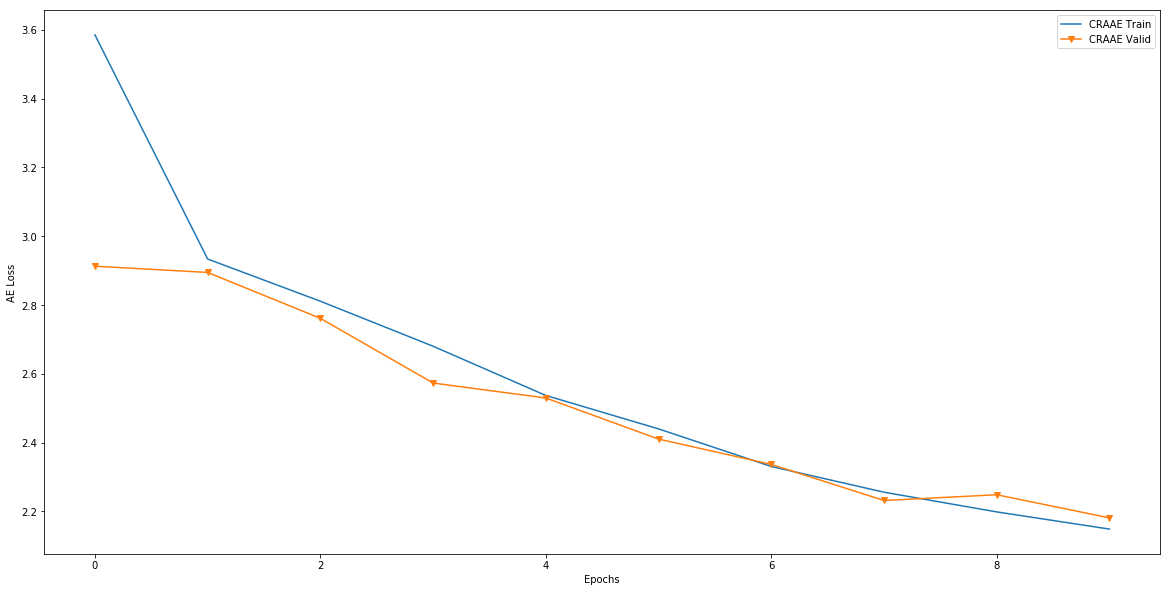

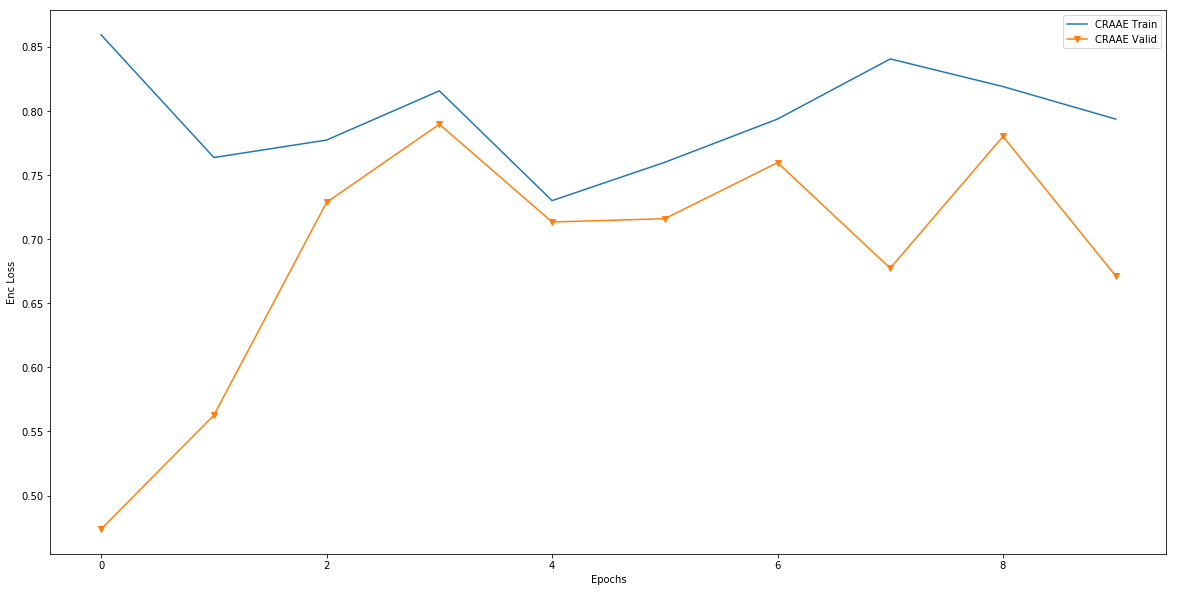

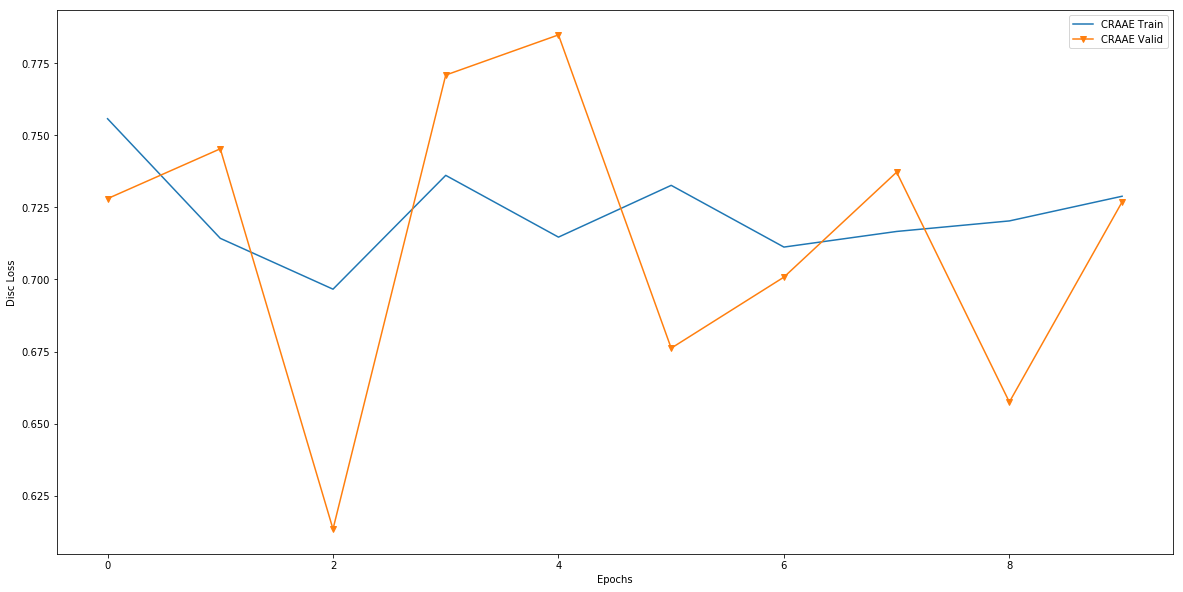

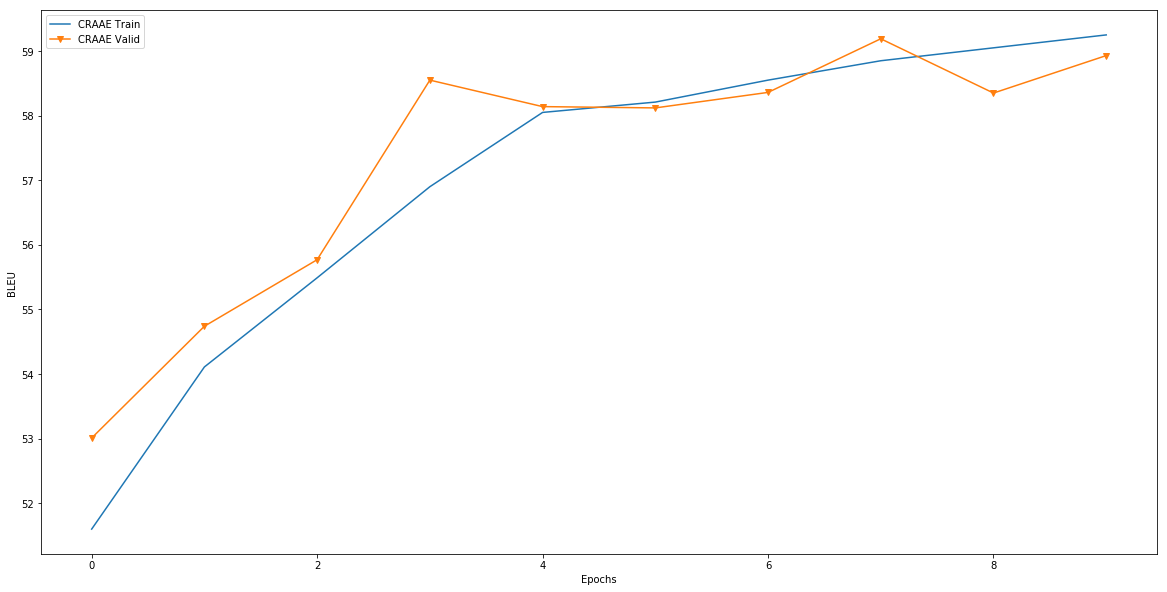

========== Start epoch 11 at 01:40:24 ==========
Epoch  11 Train: BLEU: 59.25, AE loss: 2.12524, Enc loss: 0.76289, Disc loss: 0.72112  at 01:46:24
Epoch  11 Valid: BLEU: 59.66, AE loss: 2.14006, Enc loss: 0.60742, Disc loss: 0.81628  at 01:46:30

Origin:  ['an elderly man crouches to lift the covering off the grill wear several shish kabab are grilling . <eos>']
Decoded: ['a man in a blue shirt is in a blue shirt and a a blue shirt . <eos>']


Random sample:
	decoded w. style M: ['a men are in a air in a field . <eos>']
	decoded w. style E: ['two men are in the street in a field . <eos>']

========== Start epoch 12 at 01:46:30 ==========
Epoch  12 Train: BLEU: 59.46, AE loss: 2.08260, Enc loss: 0.77333, Disc loss: 0.71965  at 01:52:27
Epoch  12 Valid: BLEU: 59.24, AE loss: 2.15833, Enc loss: 0.30391, Disc loss: 1.08241  at 01:52:33

Origin:  ['a man kayaks in rough water . <eos>']
Decoded: ['a man in a blue shirt is in']


Random sample:
	decoded w. style M: ['a group of people are a 

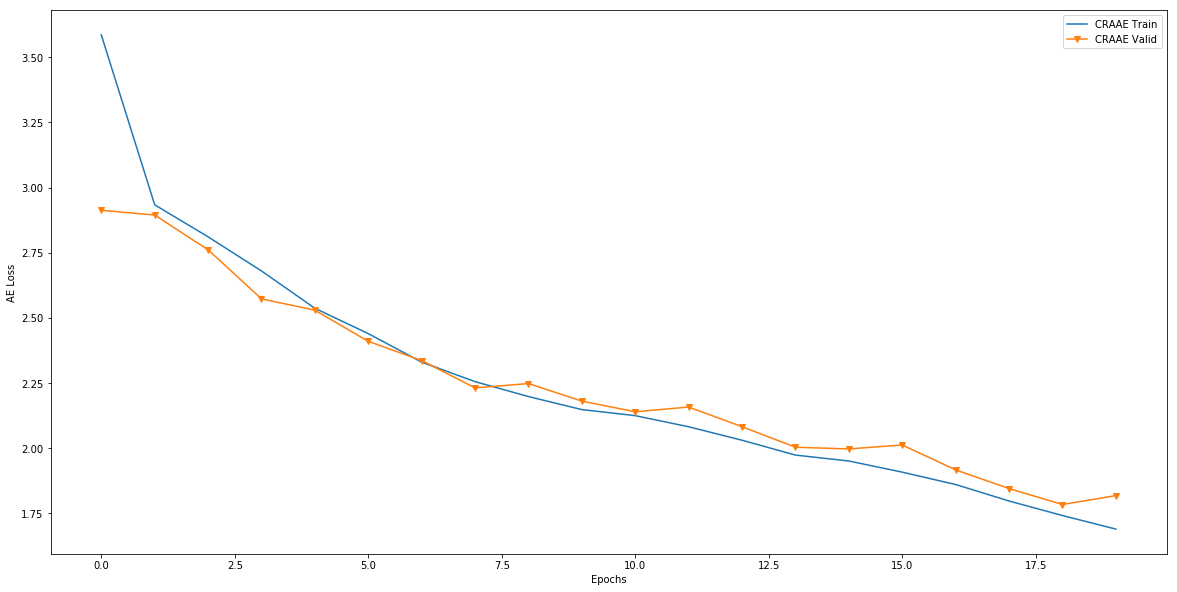

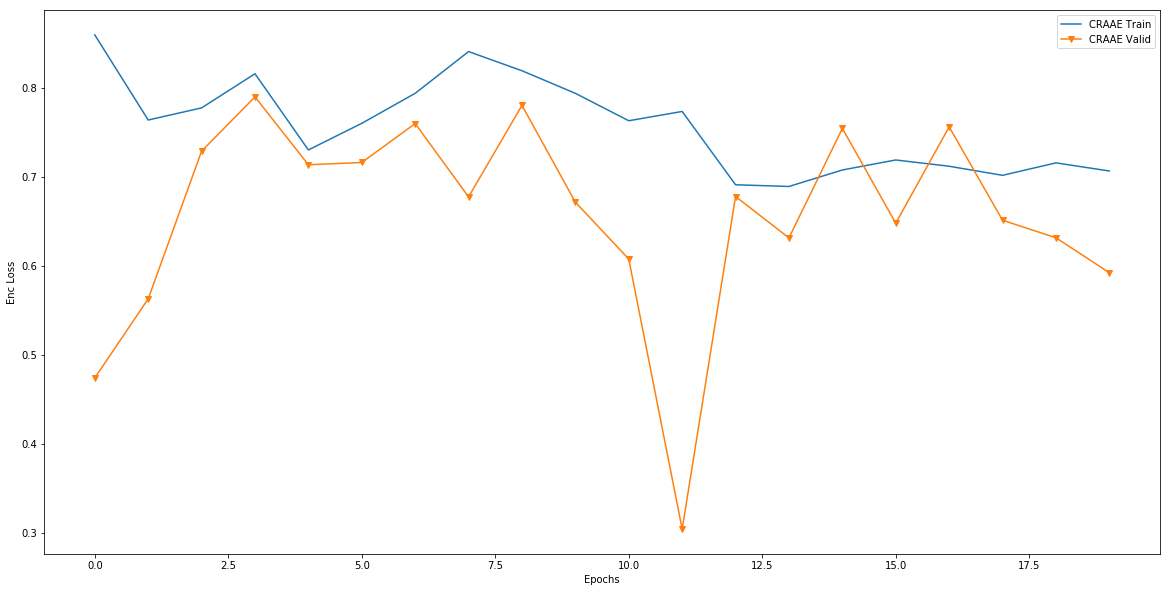

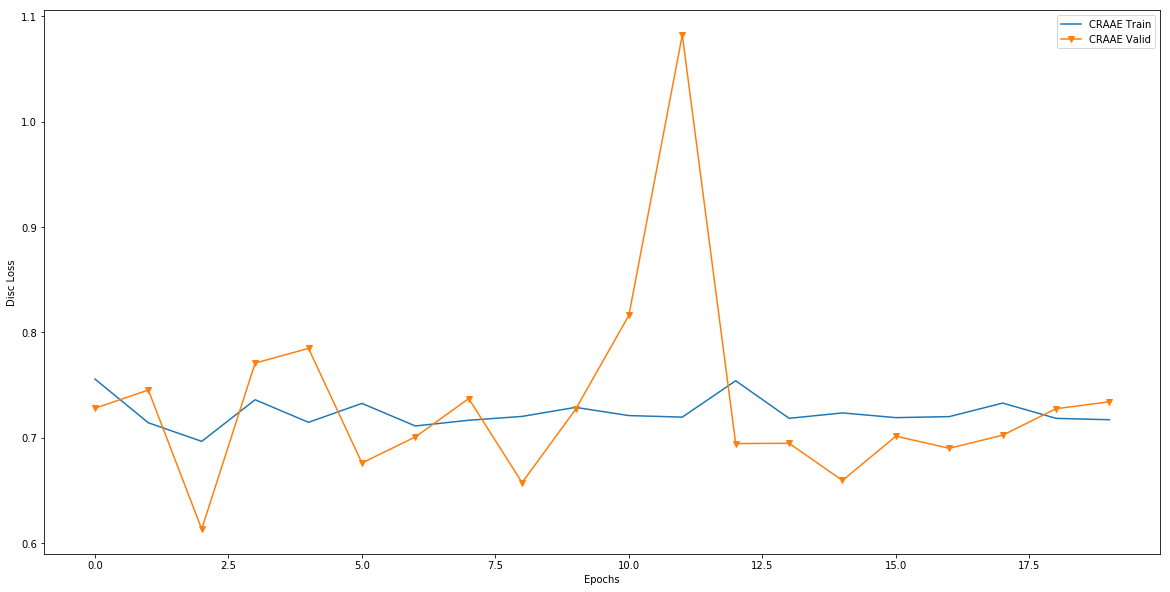

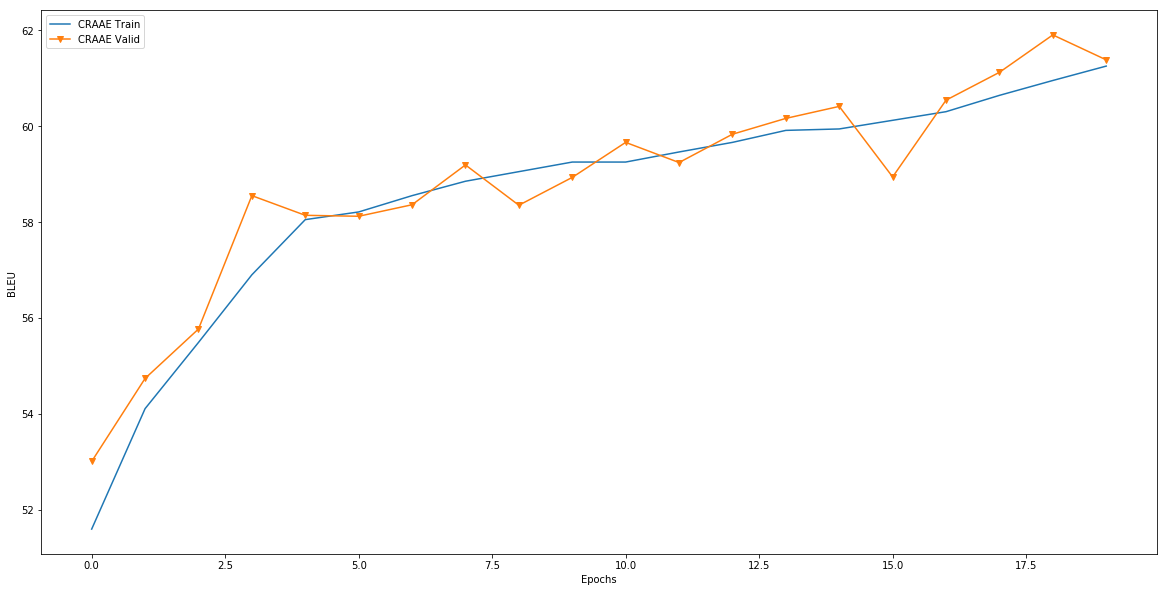

========== Start epoch 21 at 02:41:22 ==========
Epoch  21 Train: BLEU: 61.61, AE loss: 1.63177, Enc loss: 0.70592, Disc loss: 0.72164  at 02:47:20
Epoch  21 Valid: BLEU: 62.29, AE loss: 1.73004, Enc loss: 0.58462, Disc loss: 0.74145  at 02:47:26

Origin:  ['we waited in the blistering cold for you <eos>']
Decoded: ["you 're a fuckin of my door i 'm"]


Random sample:
	decoded w. style M: ['a woman is playing a bicycle in a field with a crowd . <eos>']
	decoded w. style E: ['a group of people are playing a large field in a park . <eos>']

========== Start epoch 22 at 02:47:27 ==========
Epoch  22 Train: BLEU: 61.90, AE loss: 1.58214, Enc loss: 0.70499, Disc loss: 0.73070  at 02:53:27
Epoch  22 Valid: BLEU: 61.88, AE loss: 1.66420, Enc loss: 0.71214, Disc loss: 0.69546  at 02:53:33

Origin:  ['an old man reading a paper in a restaurant . <eos>']
Decoded: ['an older man in the air and white and two people']


Random sample:
	decoded w. style M: ['a person playing a ball on a group of peo

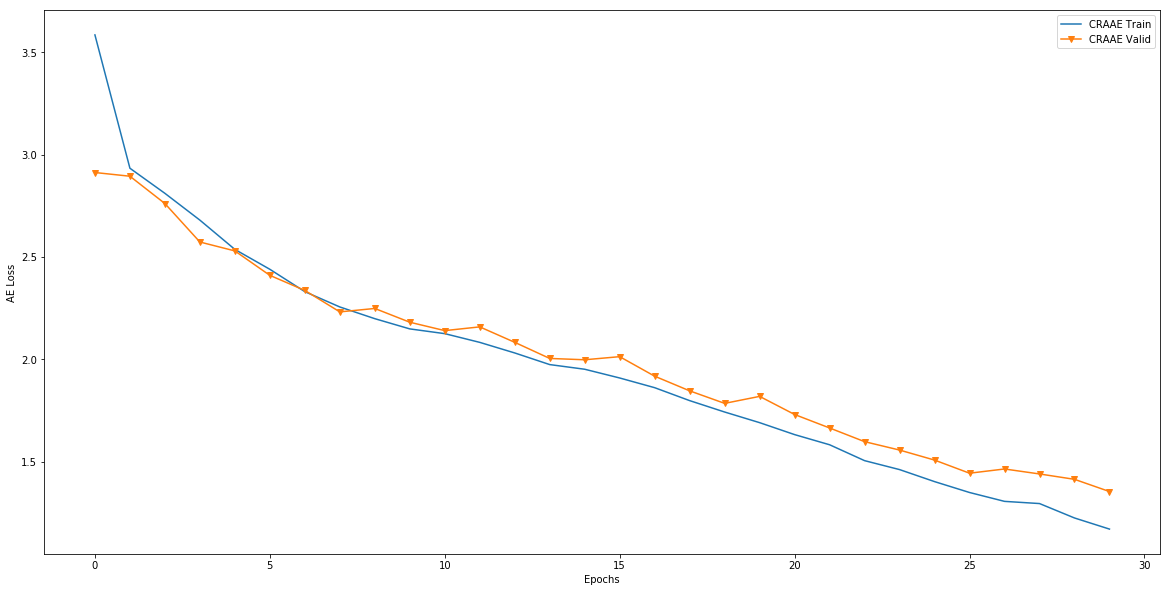

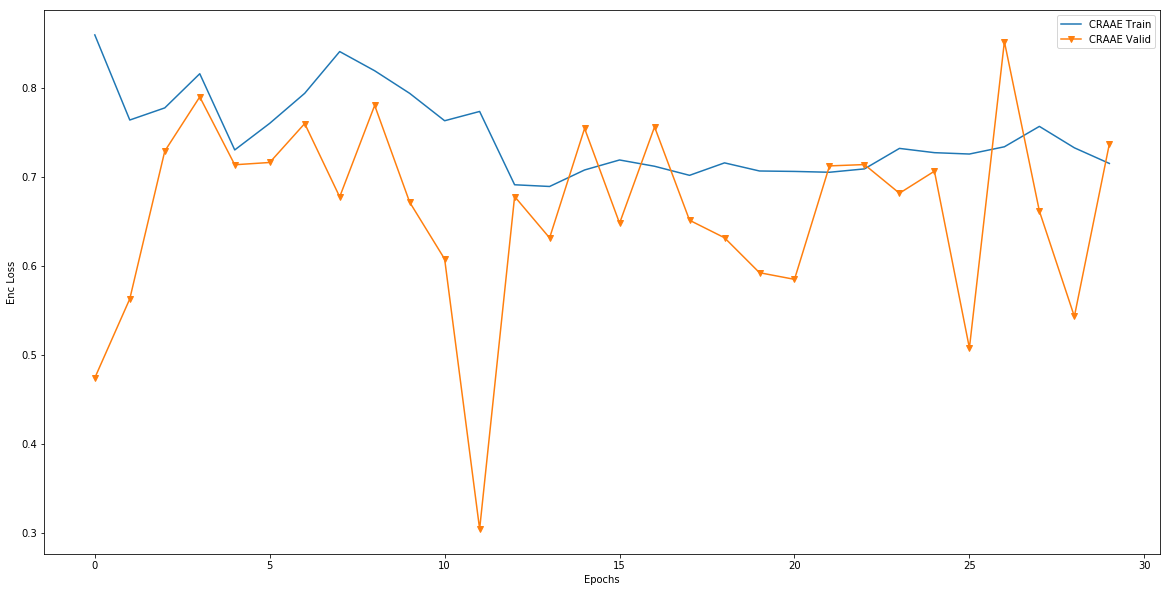

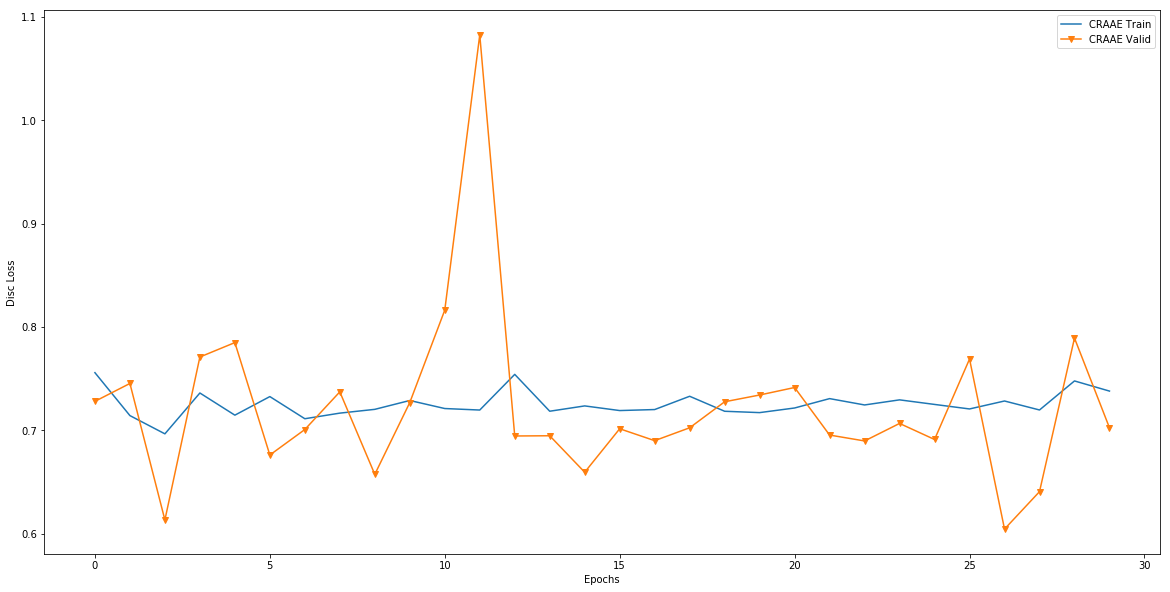

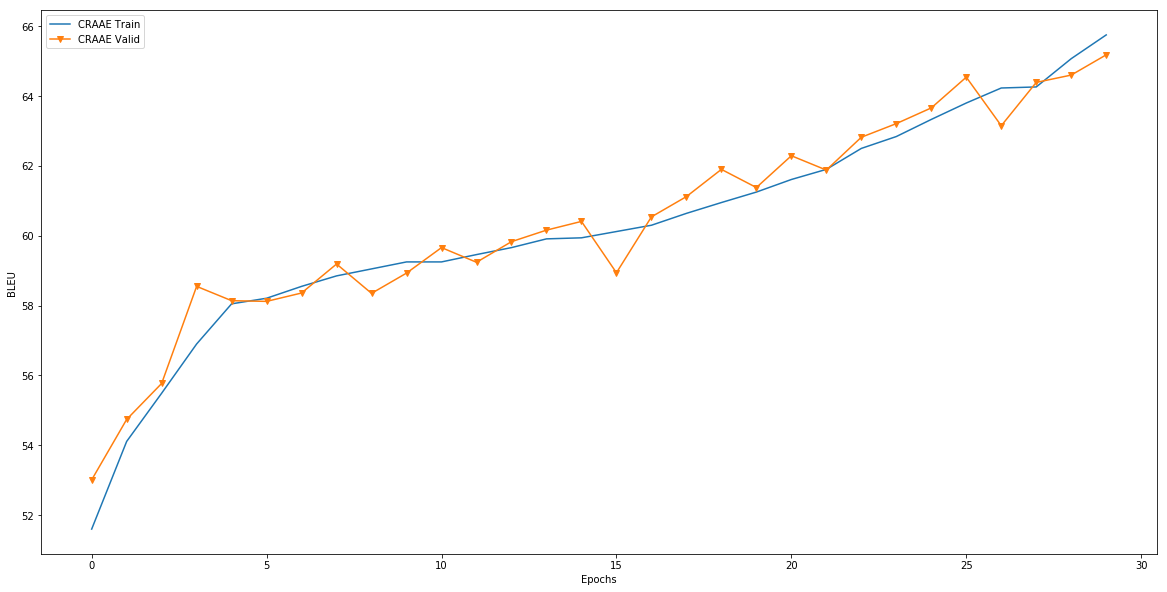

========== Start epoch 31 at 03:42:34 ==========
Epoch  31 Train: BLEU: 65.96, AE loss: 1.15114, Enc loss: 0.73176, Disc loss: 0.72836  at 03:48:34
Epoch  31 Valid: BLEU: 65.71, AE loss: 1.32471, Enc loss: 0.64380, Disc loss: 0.75492  at 03:48:40

Origin:  ['youralltraptinmyhead <eos>']
Decoded: ['and get']


Random sample:
	decoded w. style M: ['so it feels like empty without <eos>']
	decoded w. style E: ['what it was like empty without <eos>']

========== Start epoch 32 at 03:48:40 ==========
Epoch  32 Train: BLEU: 66.29, AE loss: 1.12431, Enc loss: 0.73168, Disc loss: 0.71741  at 03:54:41
Epoch  32 Valid: BLEU: 65.64, AE loss: 1.36010, Enc loss: 0.66559, Disc loss: 0.70308  at 03:54:47

Origin:  ['a young boy in a blue shirt stands next to a woman sitting on the ground . <eos>']
Decoded: ['a young boy in a blue shirt stands next to a woman playing on the ground . <eos>']


Random sample:
	decoded w. style M: ['one soccer players with their other during the beach . <eos>']
	decoded w

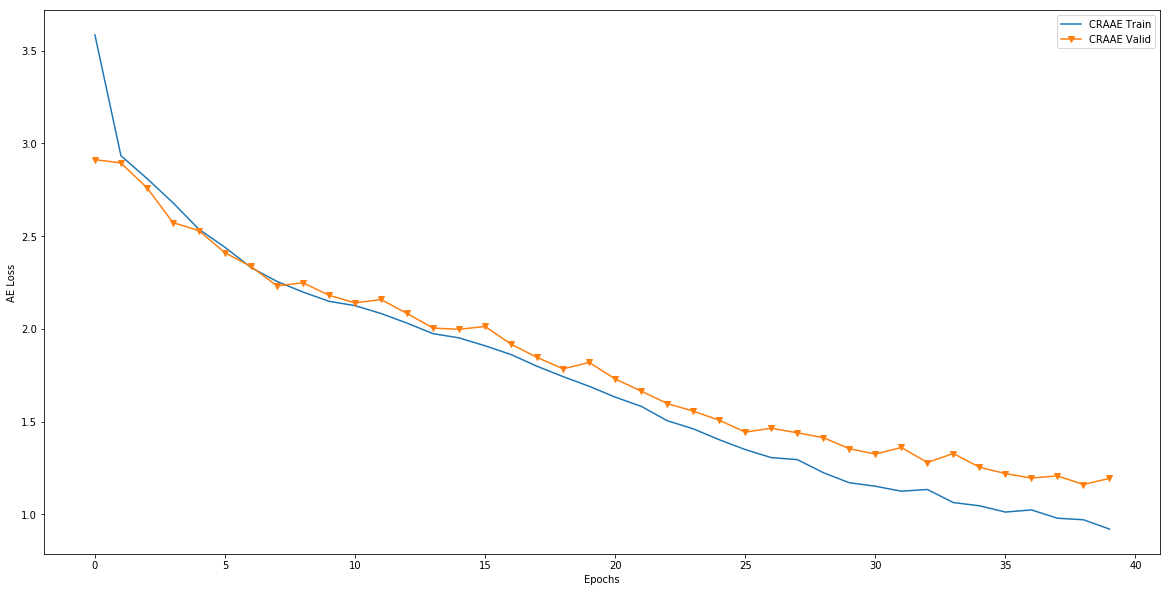

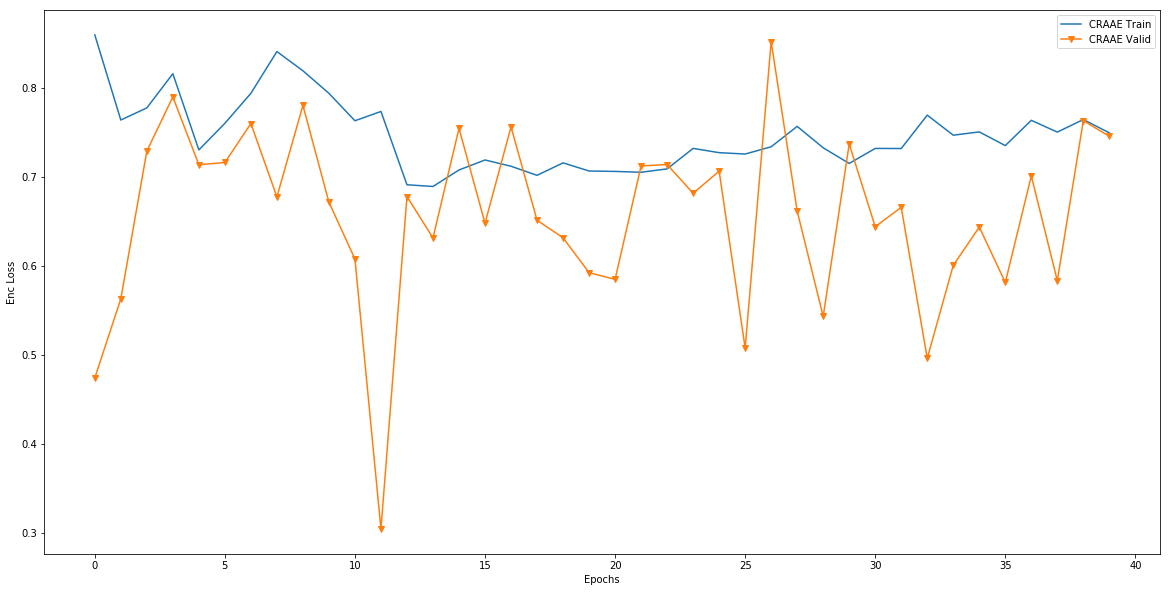

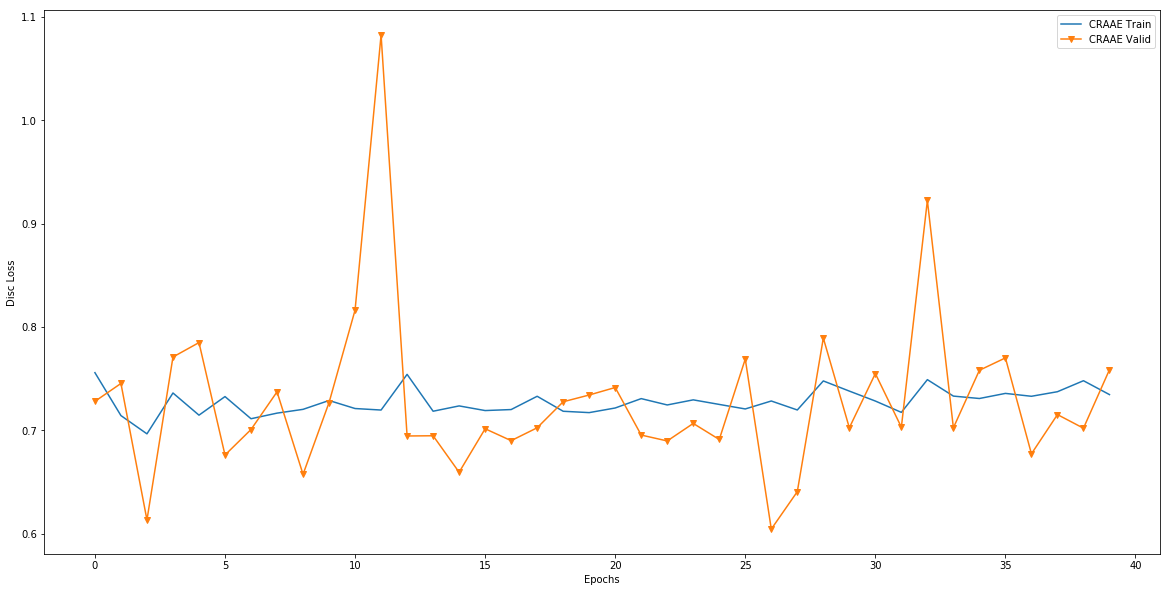

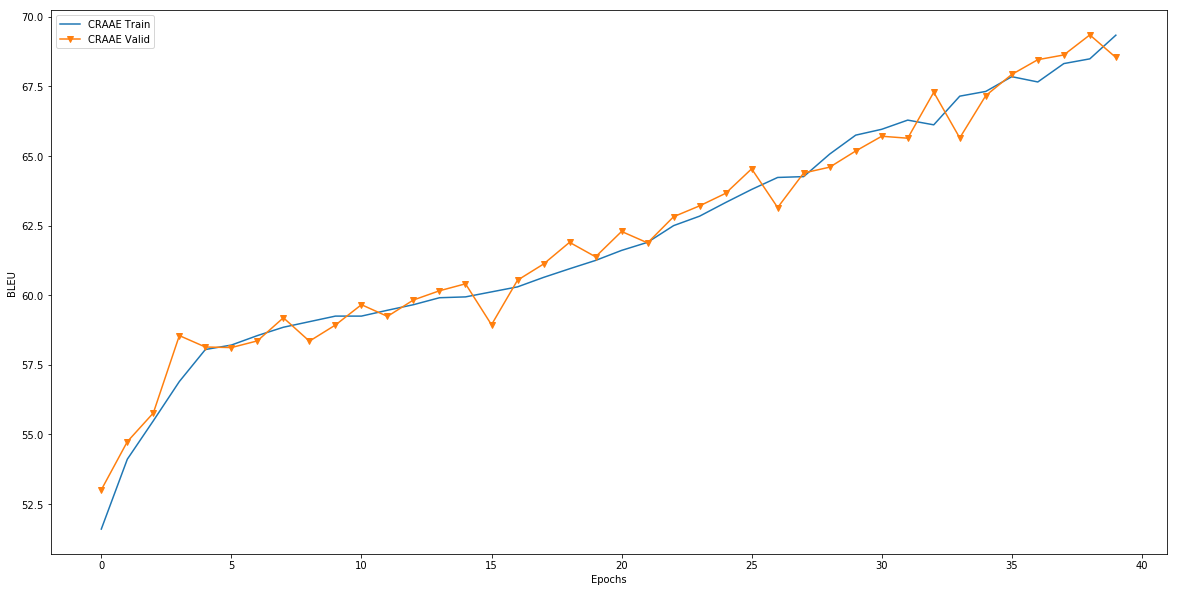

========== Start epoch 41 at 04:43:34 ==========
Epoch  41 Train: BLEU: 69.61, AE loss: 0.90530, Enc loss: 0.74560, Disc loss: 0.74550  at 04:49:32
Epoch  41 Valid: BLEU: 68.67, AE loss: 1.18779, Enc loss: 0.60133, Disc loss: 0.74041  at 04:49:38

Origin:  ['a little girl is playing with a large , white poodle in the driveway next to a police car . <eos>']
Decoded: ['a little girl with her head in a brown white hat , and a crowd of a crowd . <eos>']


Random sample:
	decoded w. style M: ['a woman in blue rides a wave over dirt down <eos>']
	decoded w. style E: ['a boy in blue rides a wave over dirt down <eos>']

========== Start epoch 42 at 04:49:38 ==========
Epoch  42 Train: BLEU: 70.05, AE loss: 0.88312, Enc loss: 0.74229, Disc loss: 0.74494  at 04:55:37
Epoch  42 Valid: BLEU: 69.19, AE loss: 1.15353, Enc loss: 0.70087, Disc loss: 0.72106  at 04:55:43

Origin:  ['a female texas a&amp m tennis player dribbling the tennis ball . <eos>']
Decoded: ['a person walking with his ice up out 

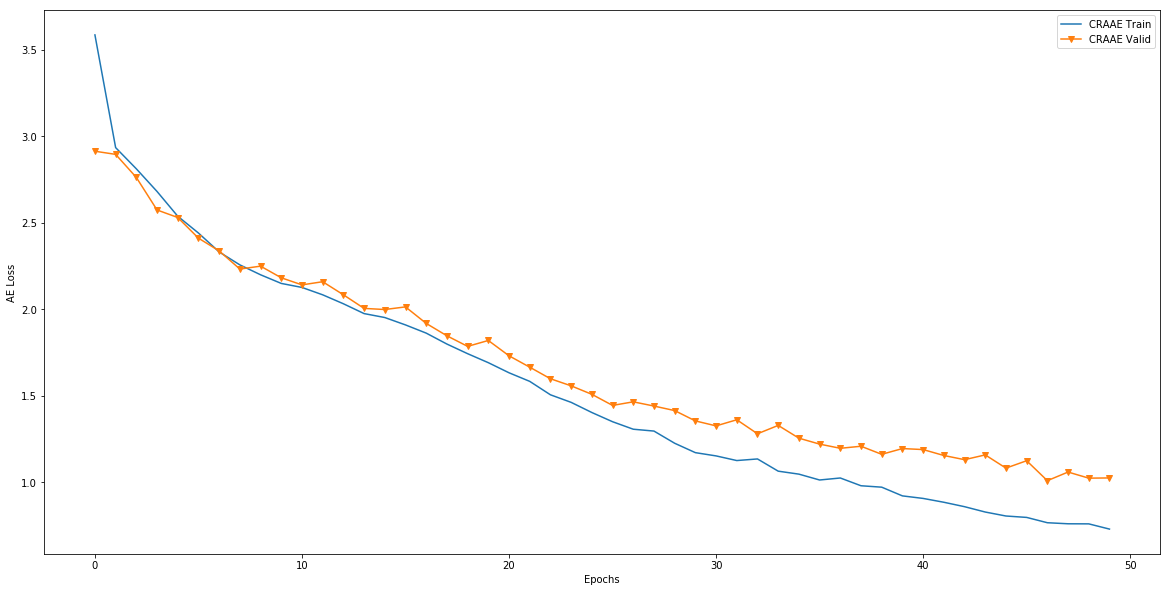

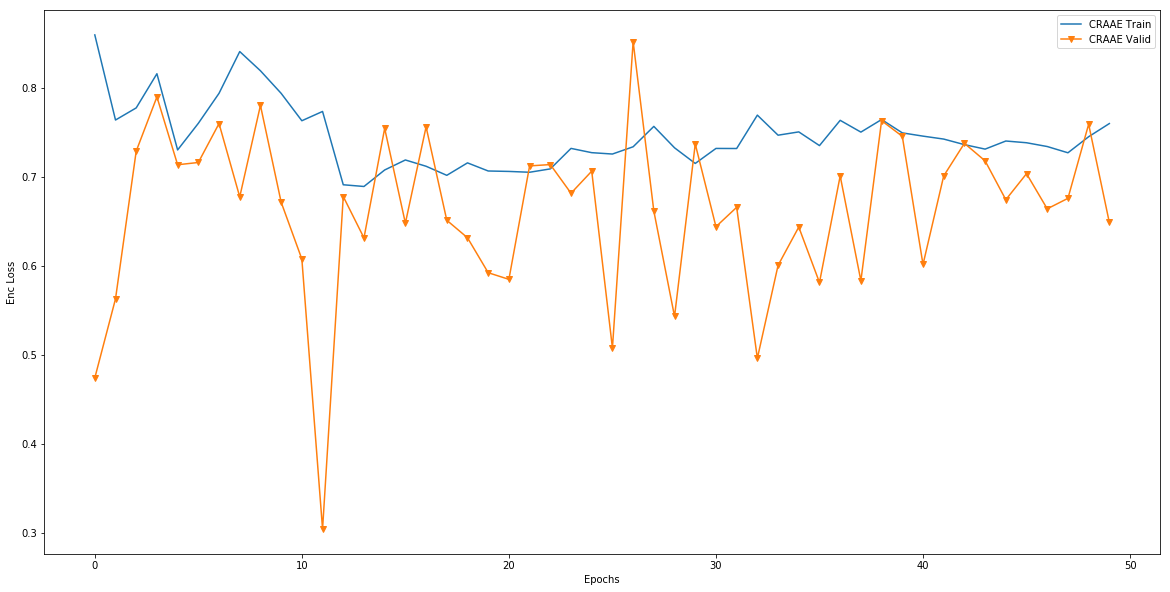

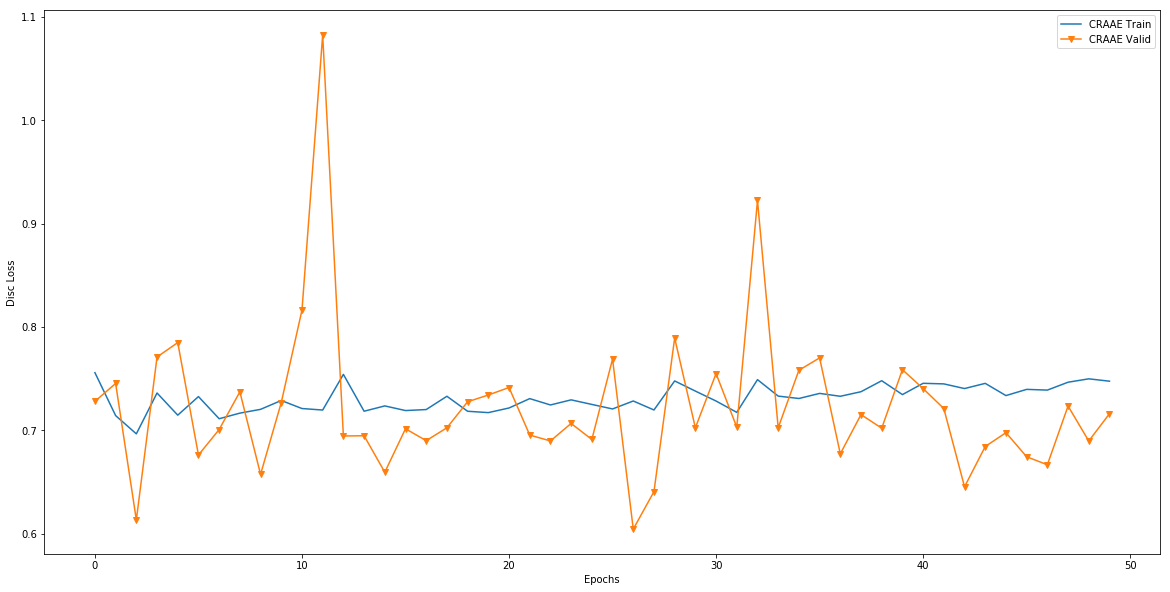

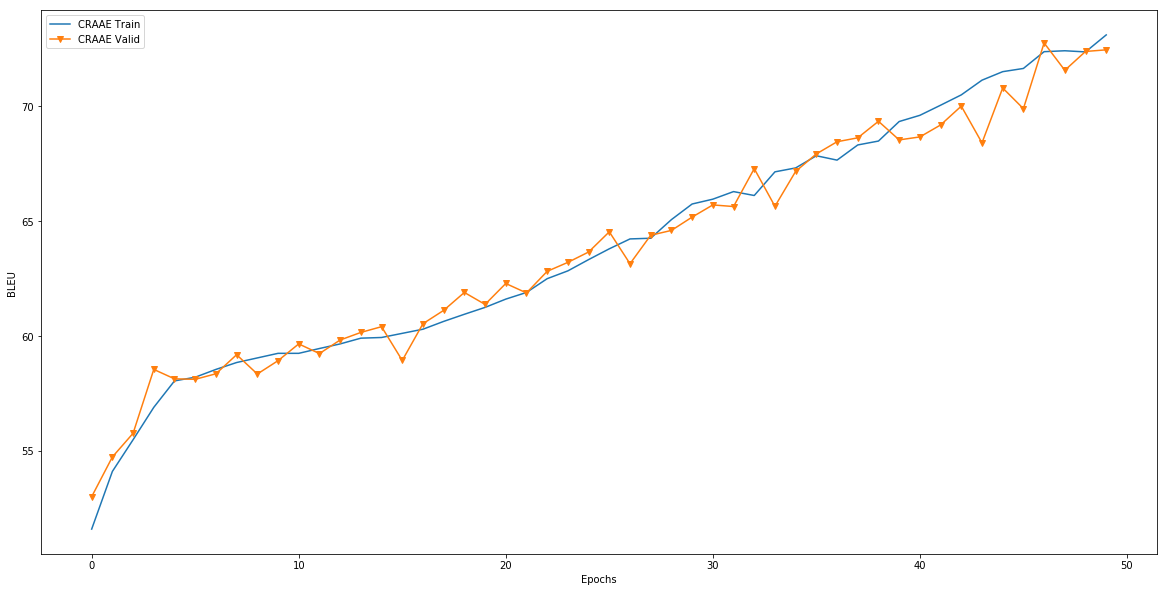

========== Start epoch 51 at 05:44:20 ==========
Epoch  51 Train: BLEU: 74.05, AE loss: 0.69142, Enc loss: 0.68284, Disc loss: 0.79236  at 05:50:18
Epoch  51 Valid: BLEU: 73.09, AE loss: 0.99281, Enc loss: 0.73399, Disc loss: 0.70370  at 05:50:24

Origin:  ['female distance runner participating in a race . <eos>']
Decoded: ['male workers stand around in a race with trees']


Random sample:
	decoded w. style M: ['some time is building for attention to arrive <eos>']
	decoded w. style E: ['or me so cold come at me <eos>']

========== Start epoch 52 at 05:50:24 ==========
Epoch  52 Train: BLEU: 74.63, AE loss: 0.66356, Enc loss: 0.74043, Disc loss: 0.72916  at 05:56:19
Epoch  52 Valid: BLEU: 71.75, AE loss: 1.03476, Enc loss: 0.65067, Disc loss: 0.77813  at 05:56:26

Origin:  ["the criminal cop killin ' , <eos>"]
Decoded: ['the criminal cop teacher are in front']


Random sample:
	decoded w. style M: ['a young boy in camouflage gear and sandals is running and riding a rope . <eos>']
	deco

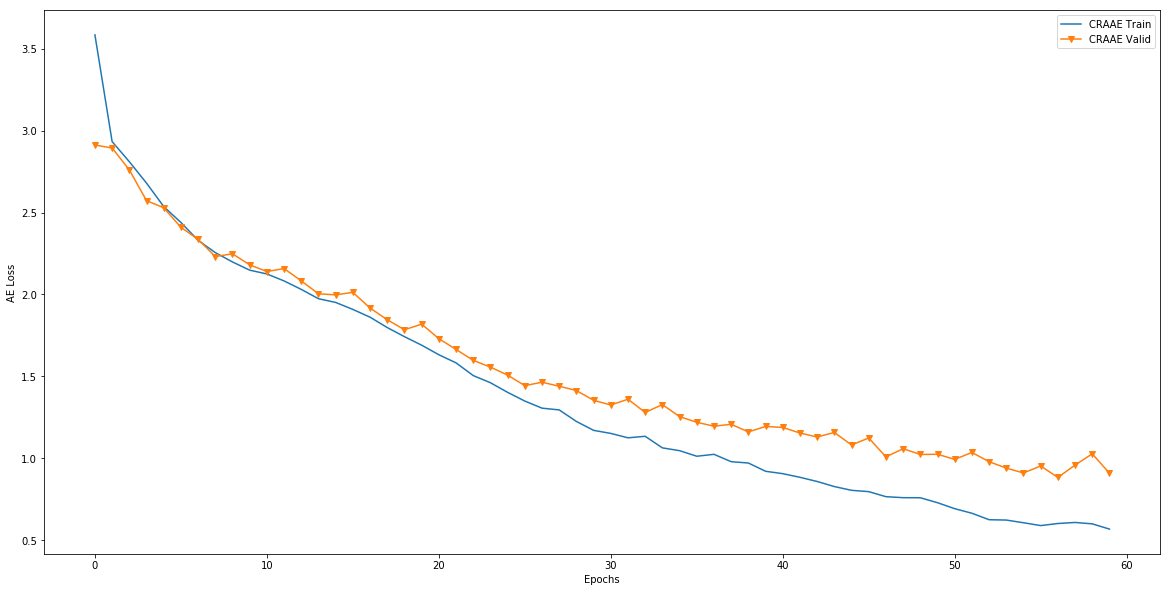

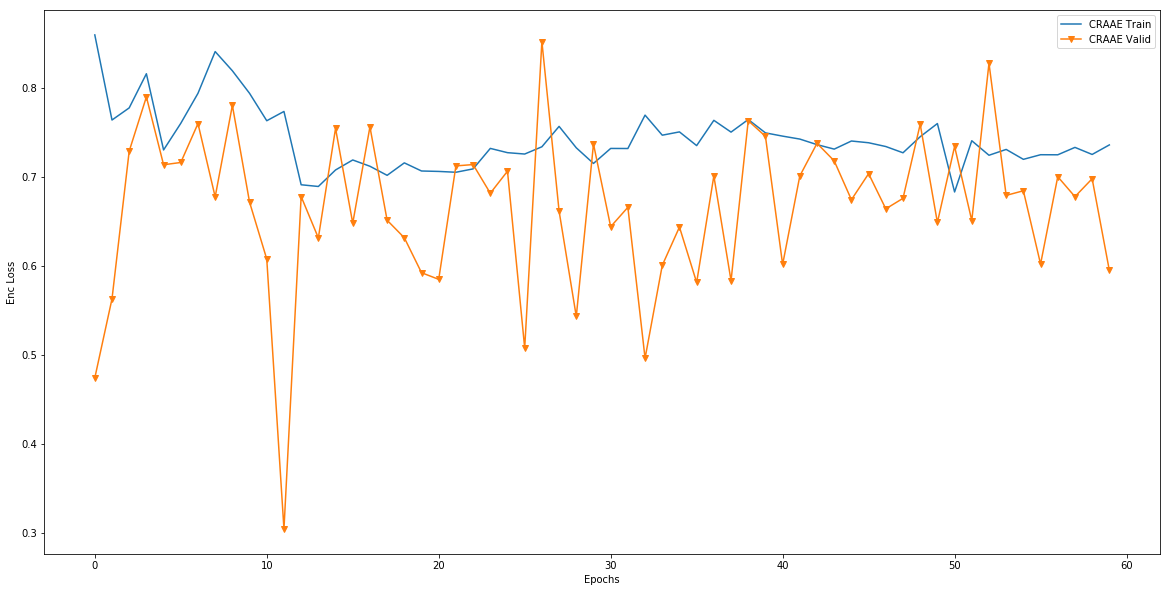

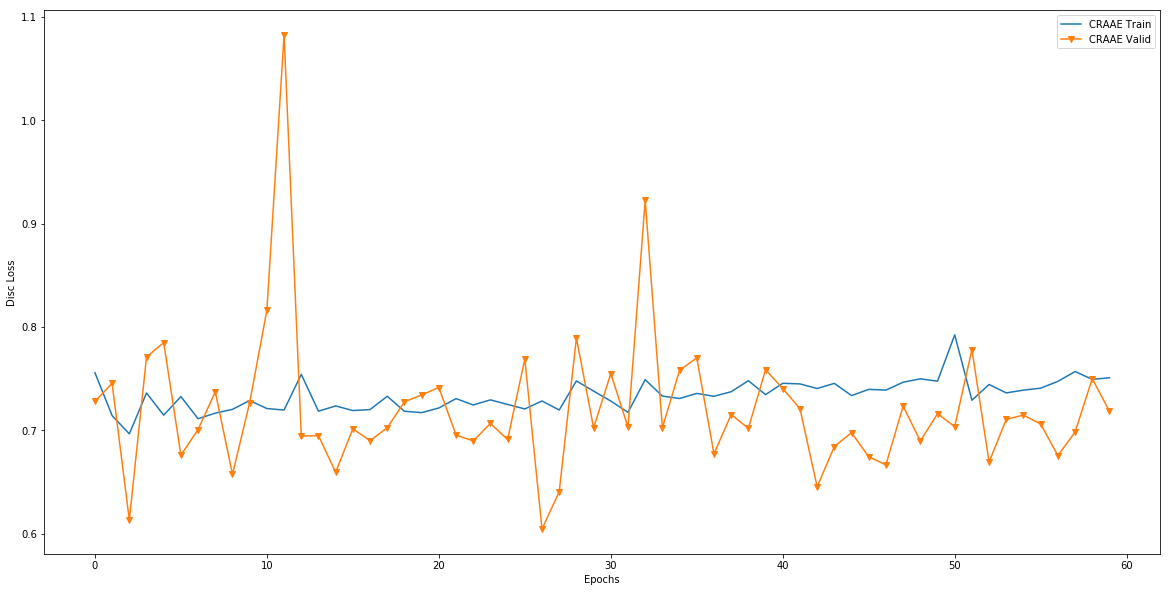

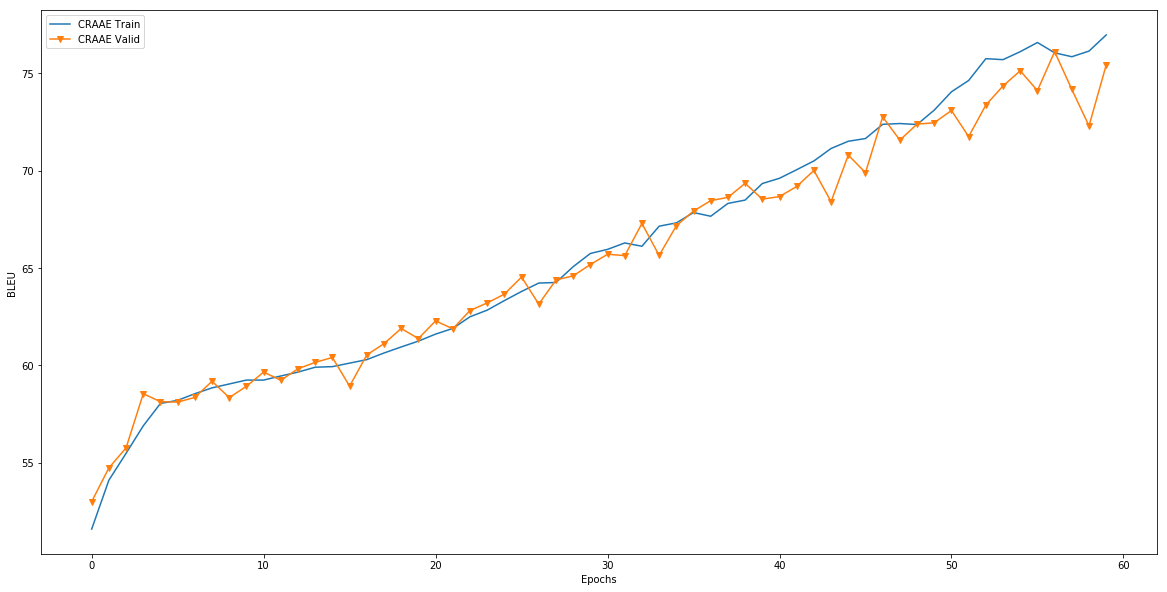

========== Start epoch 61 at 06:44:52 ==========
Epoch  61 Train: BLEU: 76.65, AE loss: 0.57715, Enc loss: 0.74763, Disc loss: 0.73375  at 06:50:49
Epoch  61 Valid: BLEU: 74.86, AE loss: 0.91139, Enc loss: 0.67373, Disc loss: 0.70795  at 06:50:56

Origin:  ['members of a band perform dressed in white while the drummer sits behind them . <eos>']
Decoded: ['members of a band getting beer in blue as the young boy is sitting on a']


Random sample:
	decoded w. style M: ['an adult and young male play behind a pose while holding a game . <eos>']
	decoded w. style E: ["several men and four ladies perform , each other 's , ren <eos>"]

========== Start epoch 62 at 06:50:56 ==========
Epoch  62 Train: BLEU: 76.86, AE loss: 0.56766, Enc loss: 0.74714, Disc loss: 0.75656  at 06:56:53
Epoch  62 Valid: BLEU: 74.84, AE loss: 0.92618, Enc loss: 0.68471, Disc loss: 0.73010  at 06:57:00

Origin:  ["shady 's back , back , back <eos>"]
Decoded: ['shady , intimidator in , , back ,']


Random sample:
	deco

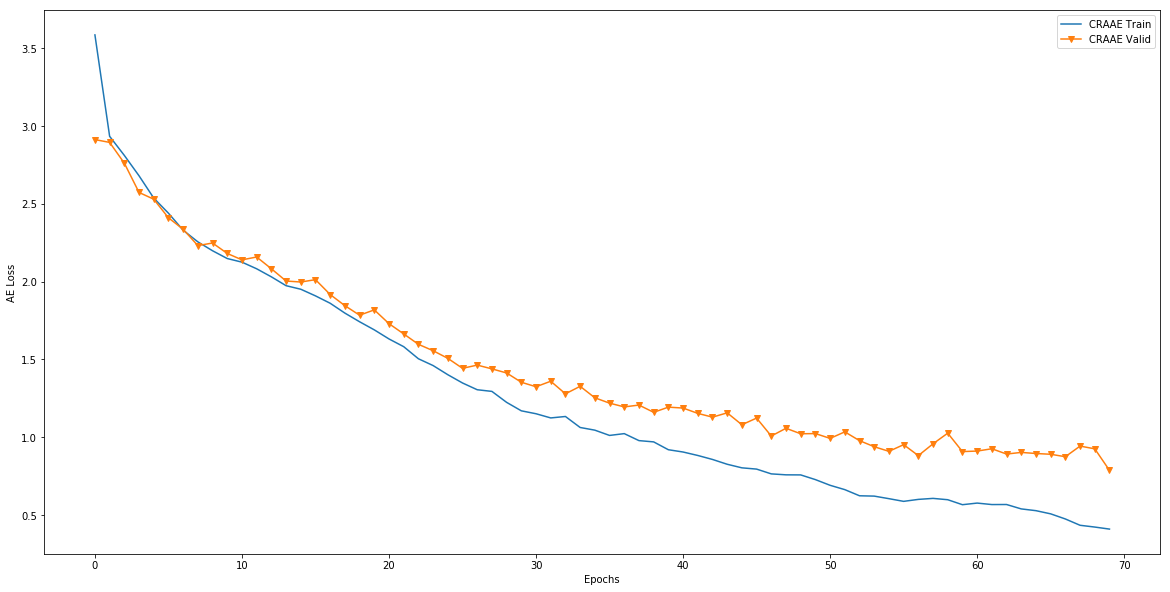

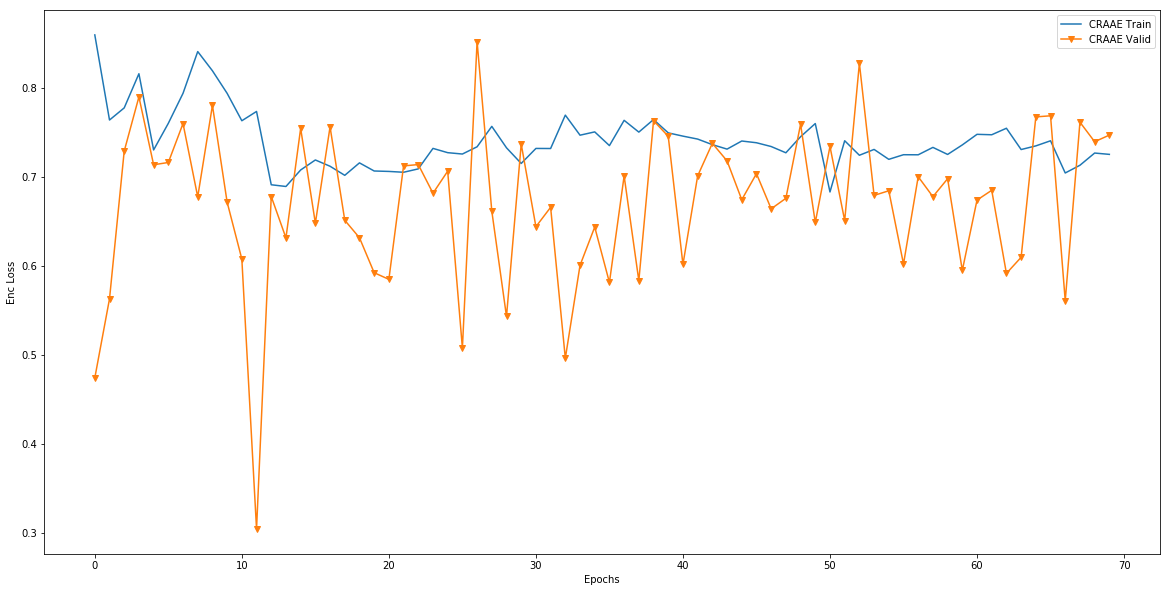

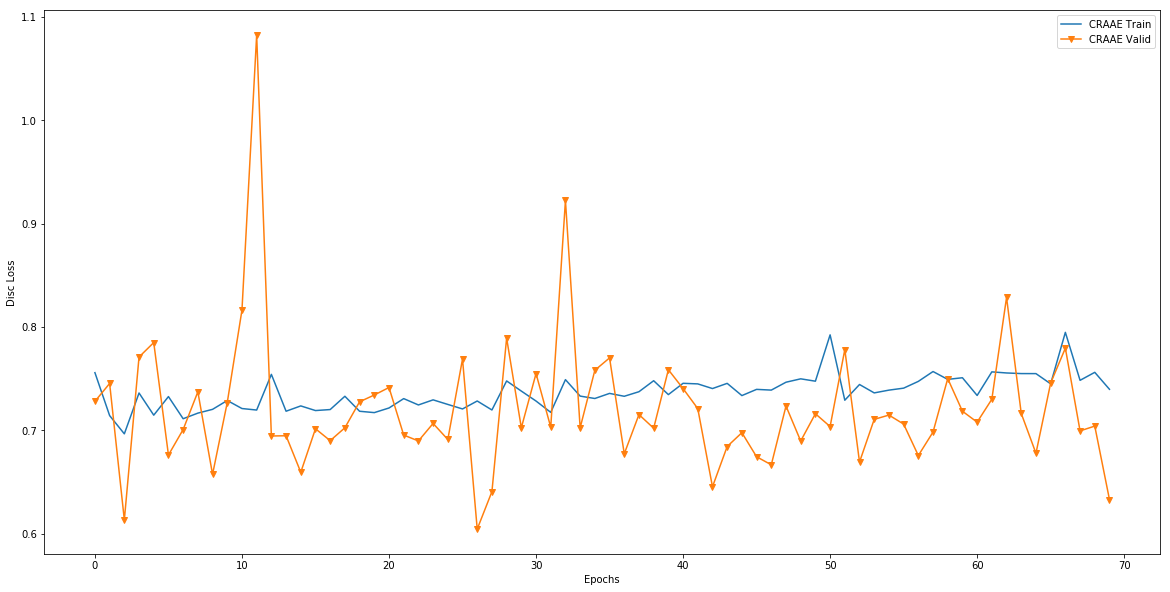

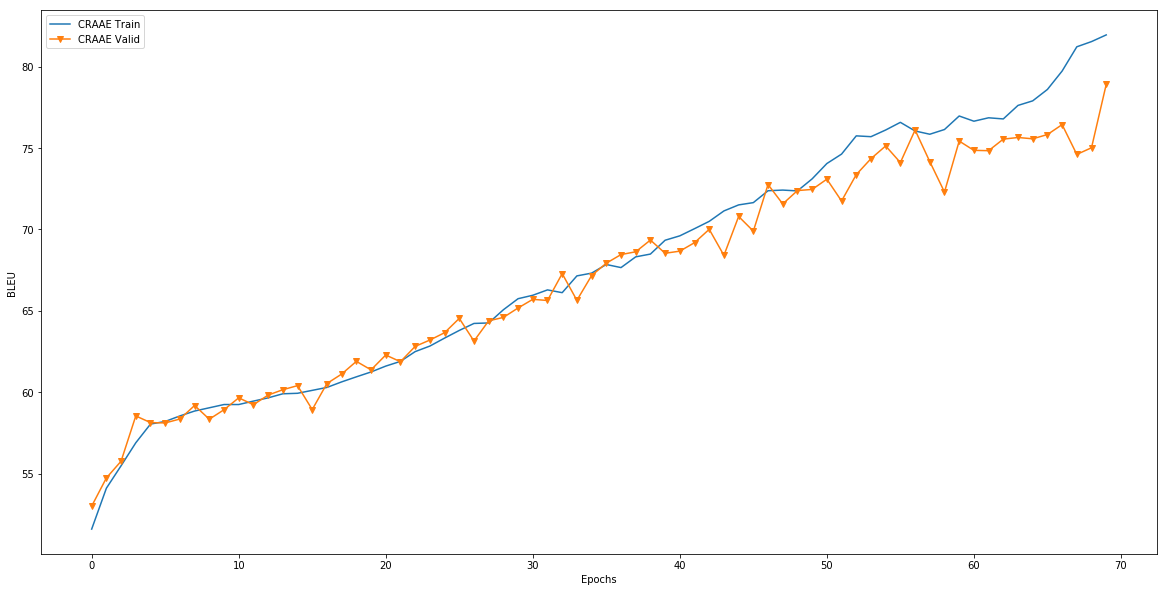

========== Start epoch 71 at 07:45:36 ==========
Epoch  71 Train: BLEU: 81.67, AE loss: 0.41684, Enc loss: 0.71005, Disc loss: 0.76304  at 07:51:33
Epoch  71 Valid: BLEU: 79.16, AE loss: 0.77647, Enc loss: 0.57611, Disc loss: 0.73613  at 07:51:40

Origin:  ['a man with black clothing is sweeping steps with a broom . <eos>']
Decoded: ['a man with black clothing is sweeping away with a car of wood']


Random sample:
	decoded w. style M: ['two ladies play and one cleaning by a waffle . <eos>']
	decoded w. style E: ['keep your tuesday , and got the past . <eos>']

========== Start epoch 72 at 07:51:40 ==========
Epoch  72 Train: BLEU: 81.55, AE loss: 0.41270, Enc loss: 0.71443, Disc loss: 0.74220  at 07:57:37
Epoch  72 Valid: BLEU: 78.15, AE loss: 0.80881, Enc loss: 0.72206, Disc loss: 0.72486  at 07:57:43

Origin:  ['a little girl climbing into a wooden playhouse . <eos>']
Decoded: ['a smiling man skateboarding through a wooden wooden sculpture on']


Random sample:
	decoded w. style M: [

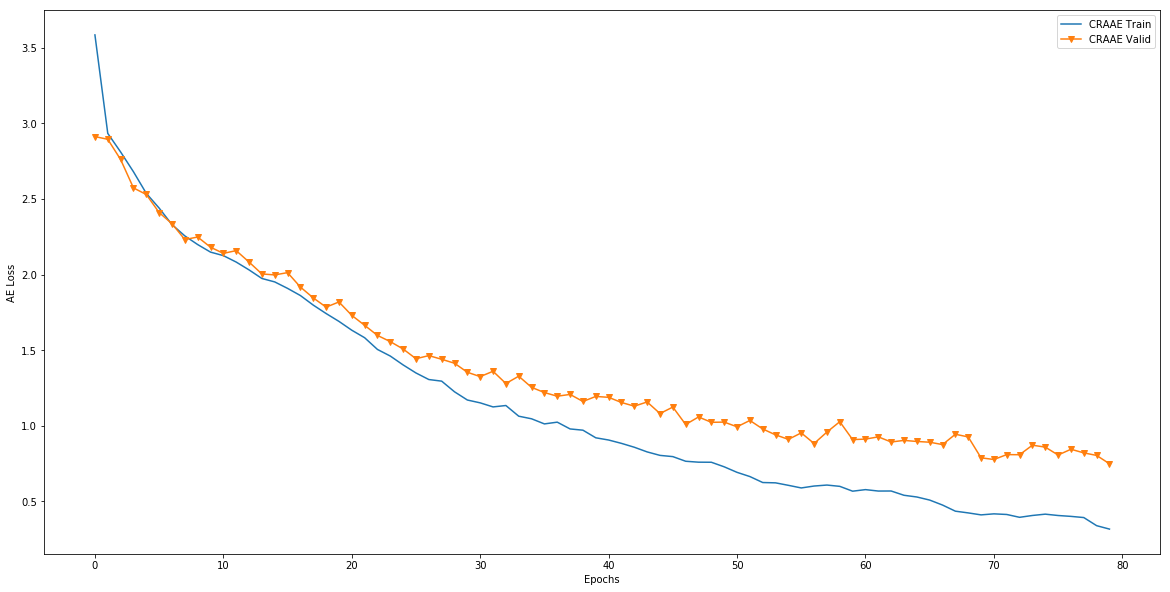

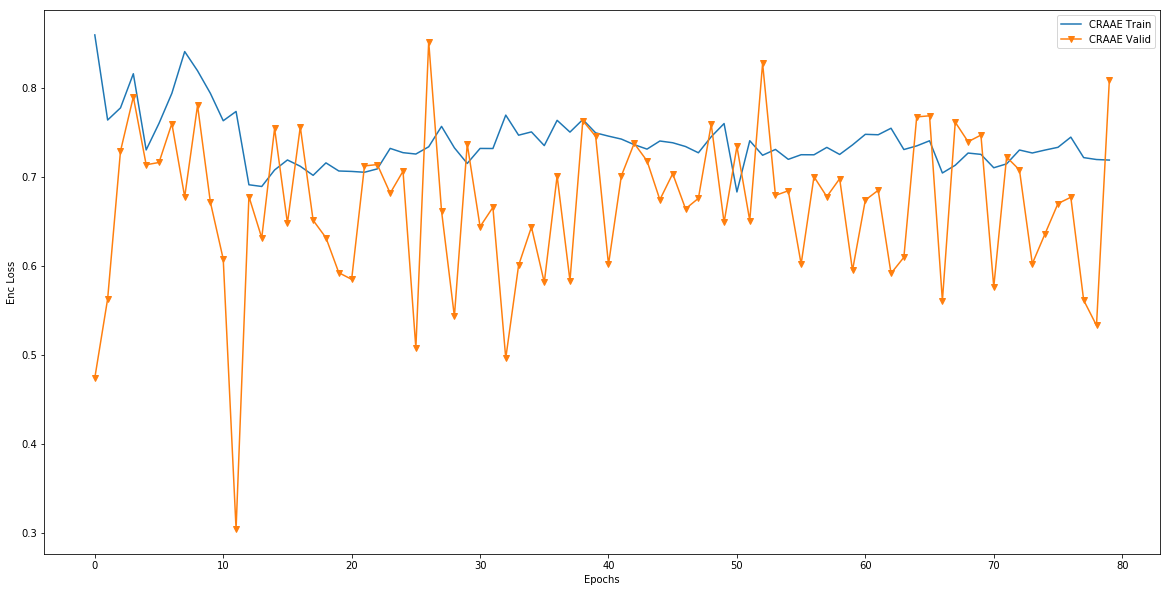

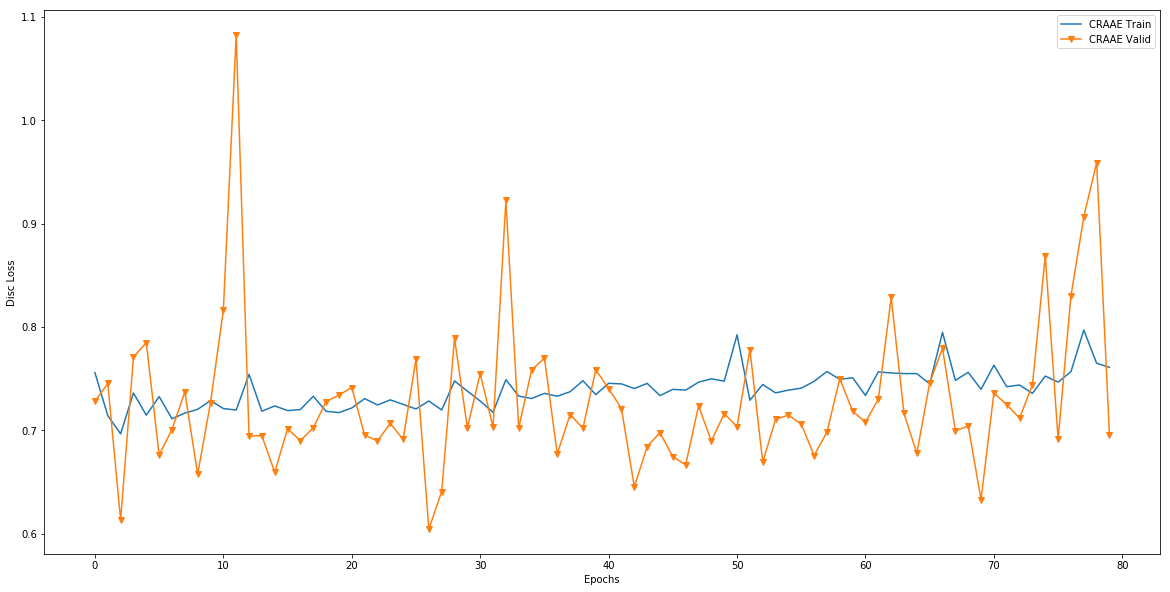

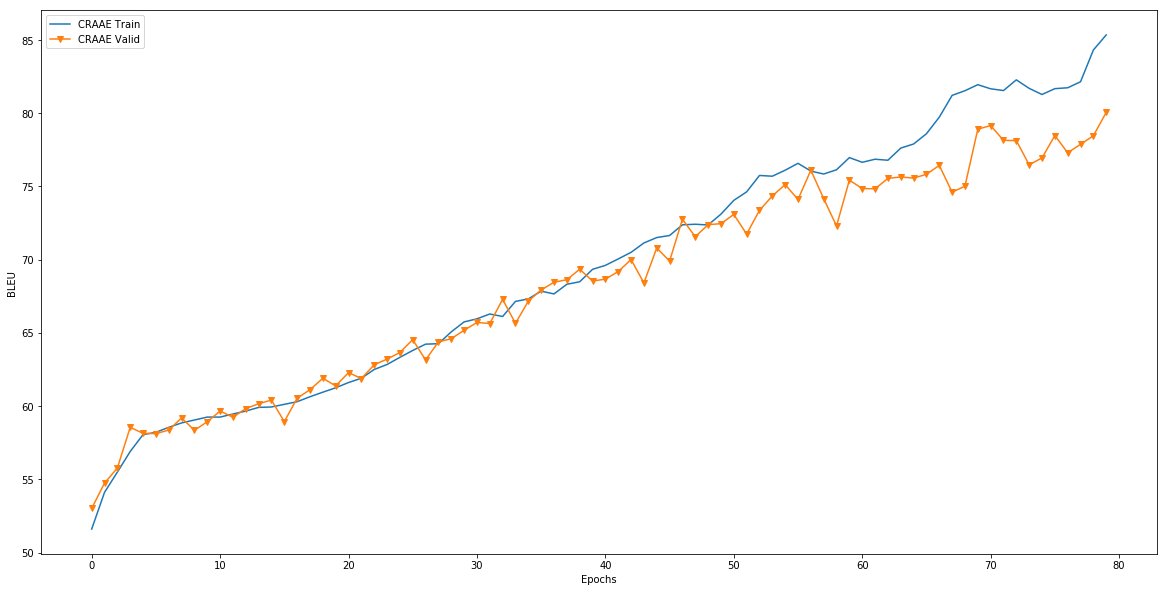

========== Start epoch 81 at 08:46:05 ==========
Epoch  81 Train: BLEU: 84.82, AE loss: 0.32499, Enc loss: 0.72189, Disc loss: 0.75230  at 08:52:03
Epoch  81 Valid: BLEU: 80.76, AE loss: 0.72787, Enc loss: 0.68638, Disc loss: 0.69704  at 08:52:09

Origin:  ['intro eminem <eos>']
Decoded: ['rich man a']


Random sample:
	decoded w. style M: ['a professional climber stands on the back of his bikes . <eos>']
	decoded w. style E: ['a thousand streets runs now on an end of building . <eos>']

========== Start epoch 82 at 08:52:09 ==========
Epoch  82 Train: BLEU: 84.41, AE loss: 0.33008, Enc loss: 0.71235, Disc loss: 0.74047  at 08:58:06
Epoch  82 Valid: BLEU: 79.16, AE loss: 0.77511, Enc loss: 0.74861, Disc loss: 0.68637  at 08:58:13

Origin:  ["four people 's silhouette carrying an object up a hill . <eos>"]
Decoded: ['four people are riding a wooden square up down in a wooden']


Random sample:
	decoded w. style M: ["here 's work inside and live , picture <eos>"]
	decoded w. style E: ["h

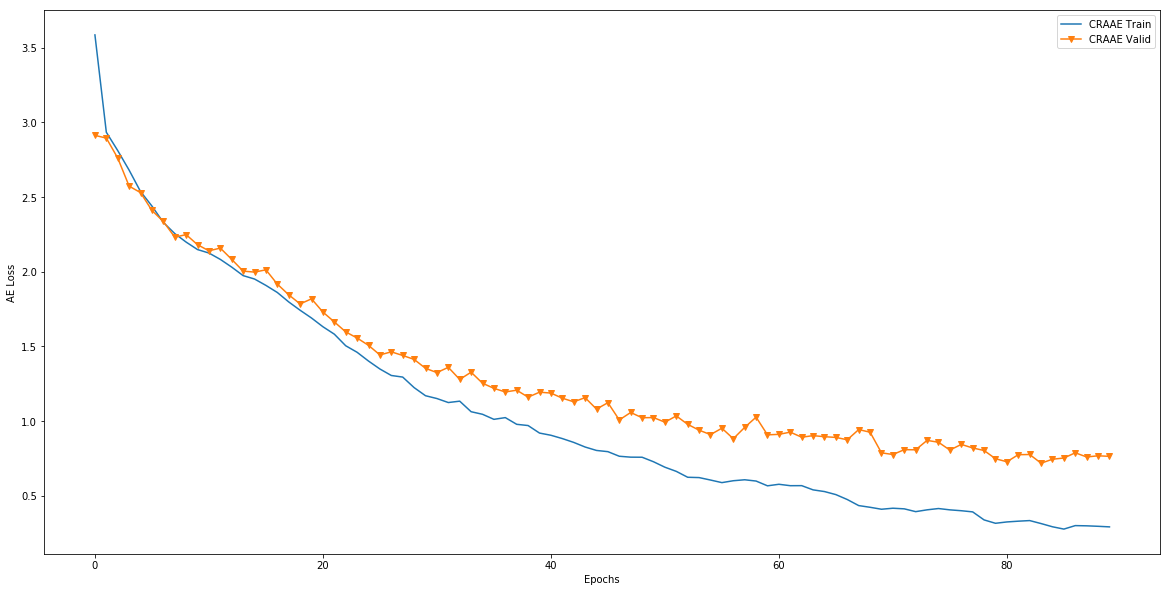

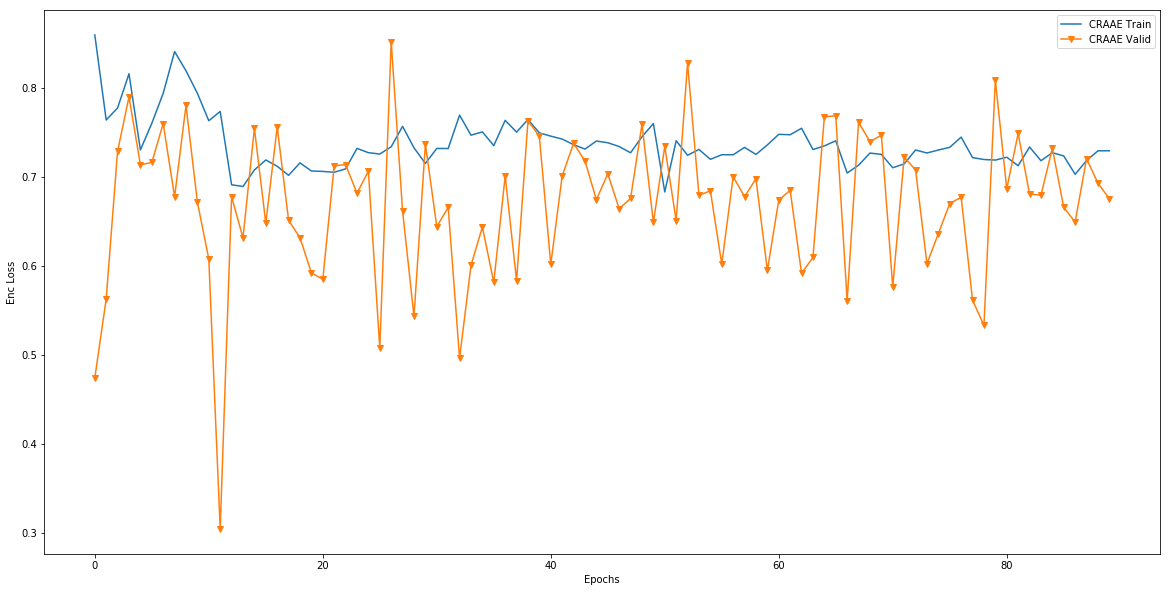

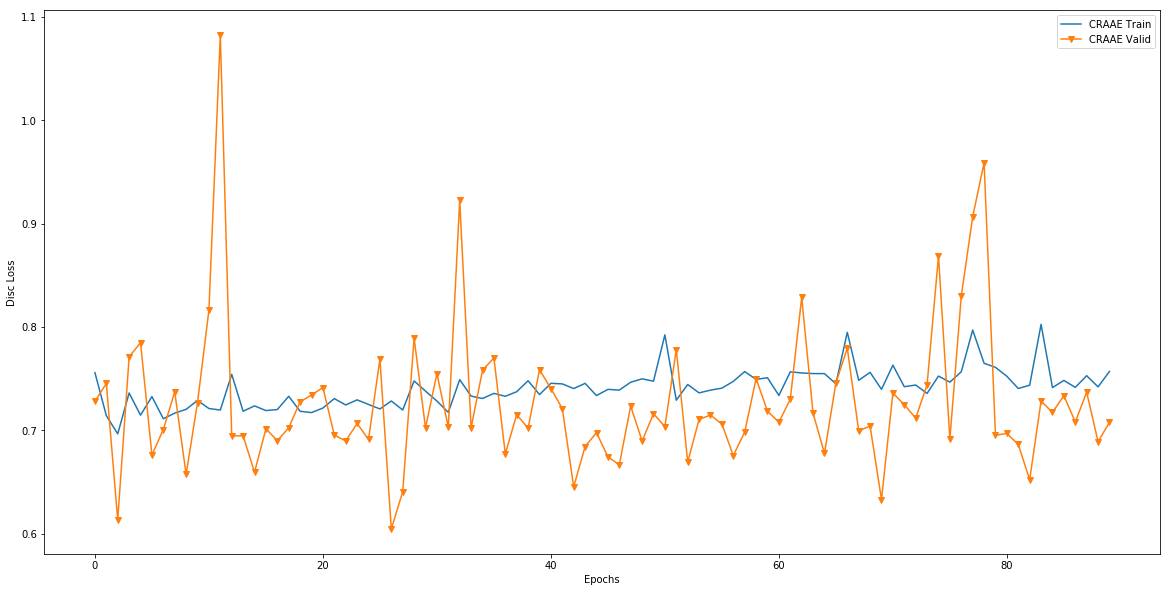

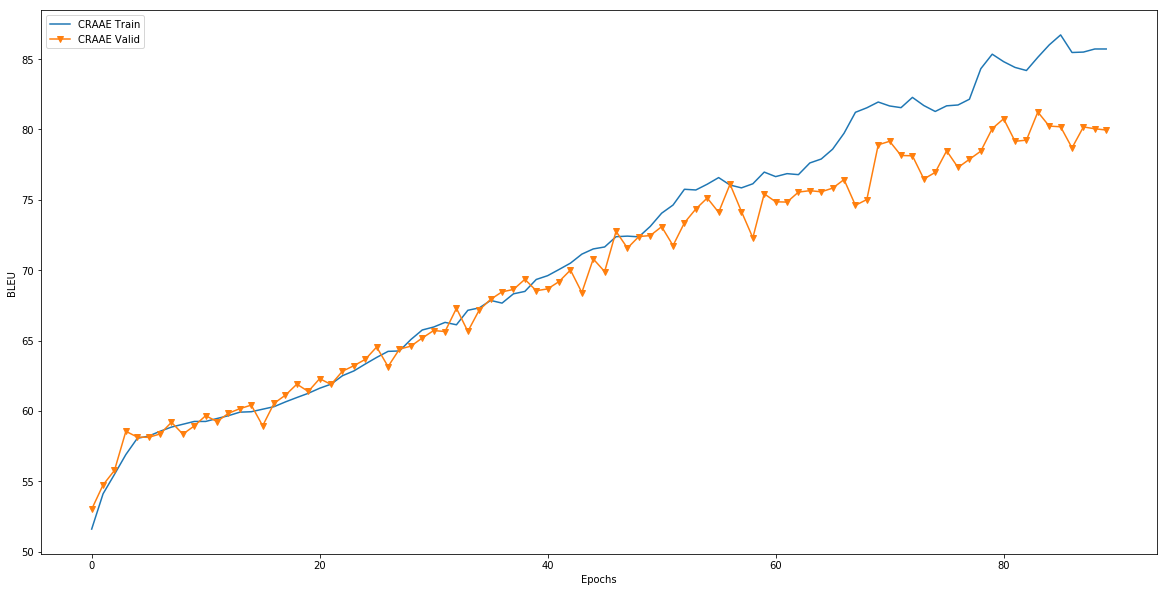

========== Start epoch 91 at 09:46:35 ==========
Epoch  91 Train: BLEU: 86.10, AE loss: 0.28379, Enc loss: 0.71115, Disc loss: 0.74682  at 09:52:30
Epoch  91 Valid: BLEU: 80.41, AE loss: 0.75262, Enc loss: 0.60246, Disc loss: 0.69140  at 09:52:36

Origin:  ['three men work at a construction site . <eos>']
Decoded: ['three men work at a construction site . <eos>']


Random sample:
	decoded w. style M: ['a lady does a child and goggles as her way placed in an arena . <eos>']
	decoded w. style E: ['a lady does wet two sheep , only cut out a zip off <eos>']

========== Start epoch 92 at 09:52:36 ==========
Epoch  92 Train: BLEU: 86.34, AE loss: 0.27616, Enc loss: 0.74245, Disc loss: 0.75198  at 09:58:32
Epoch  92 Valid: BLEU: 80.06, AE loss: 0.75860, Enc loss: 0.67659, Disc loss: 0.70241  at 09:58:38

Origin:  ['two girls giving the peace sign . <eos>']
Decoded: ['two girls enjoying the peace sign . <eos>']


Random sample:
	decoded w. style M: ['this group of people crossing a building . 

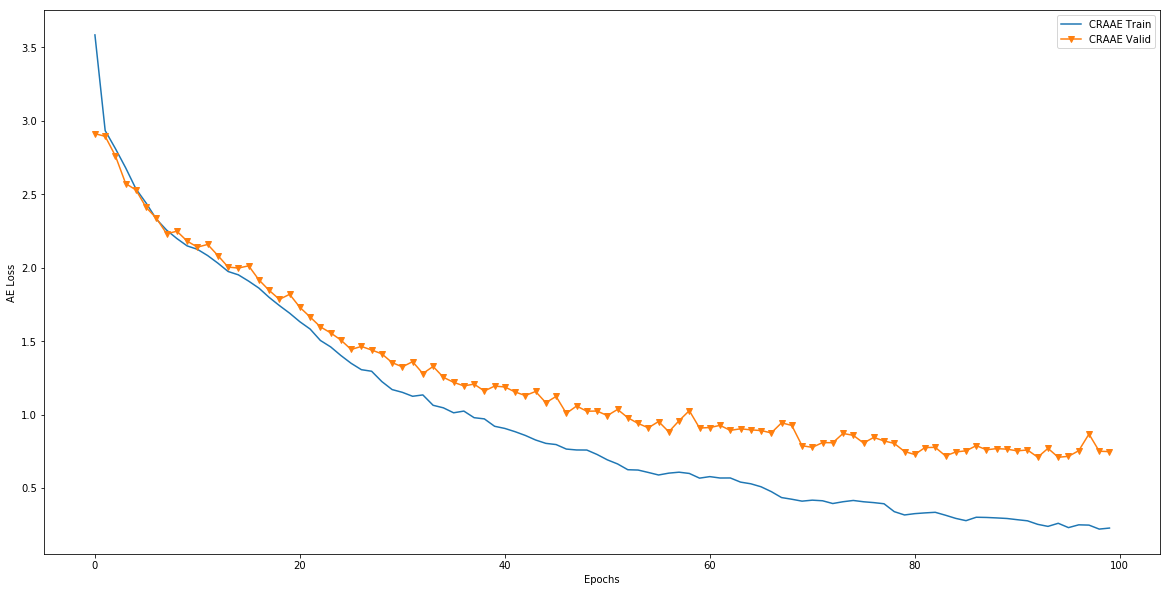

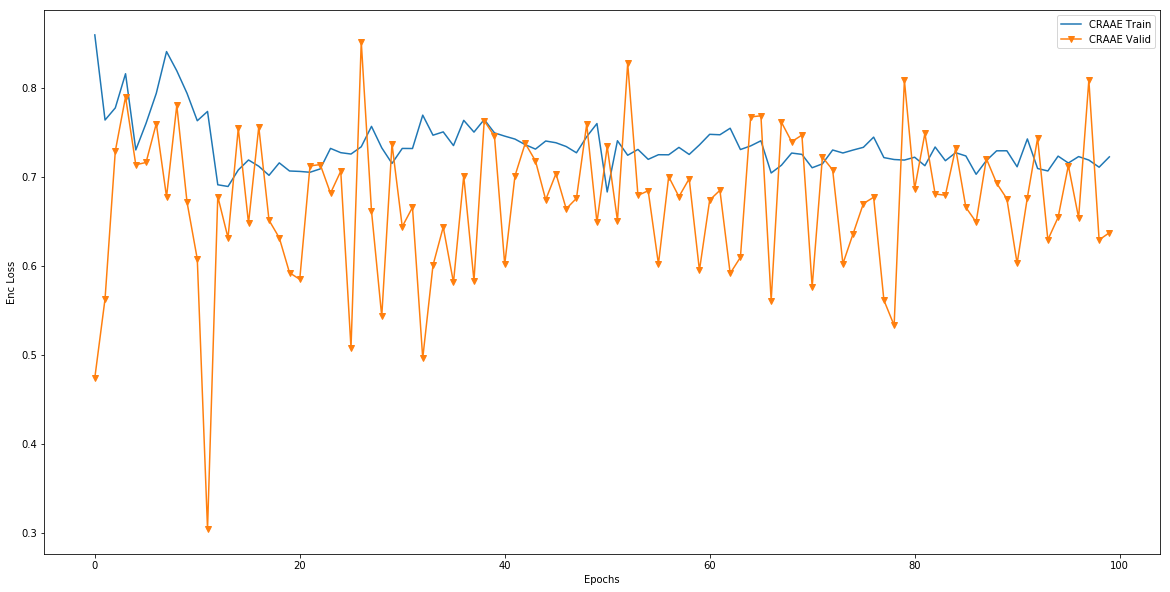

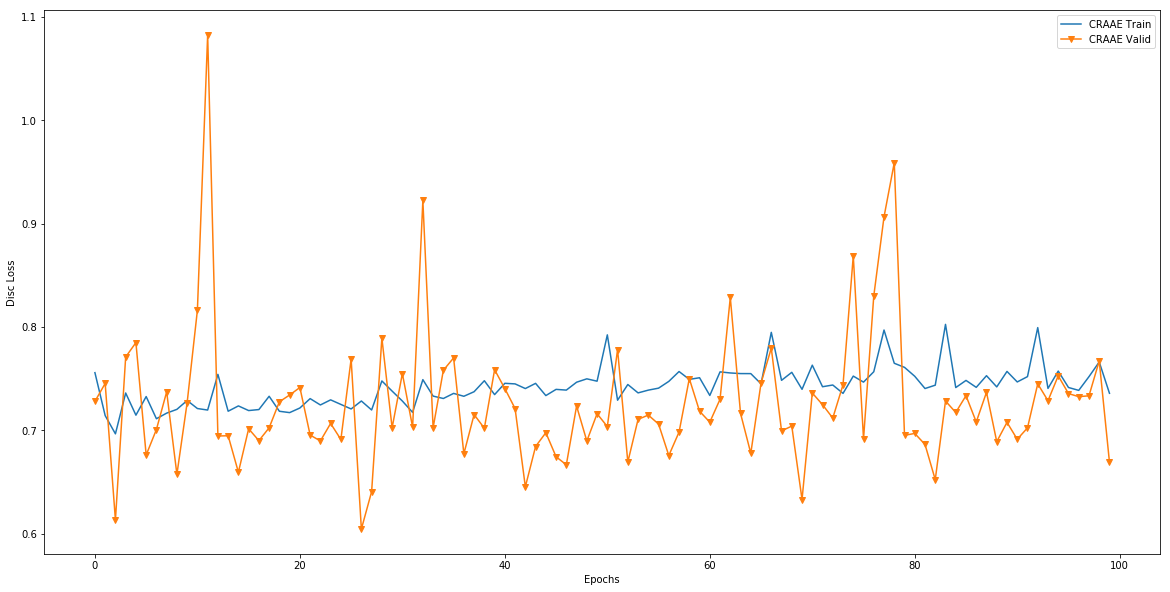

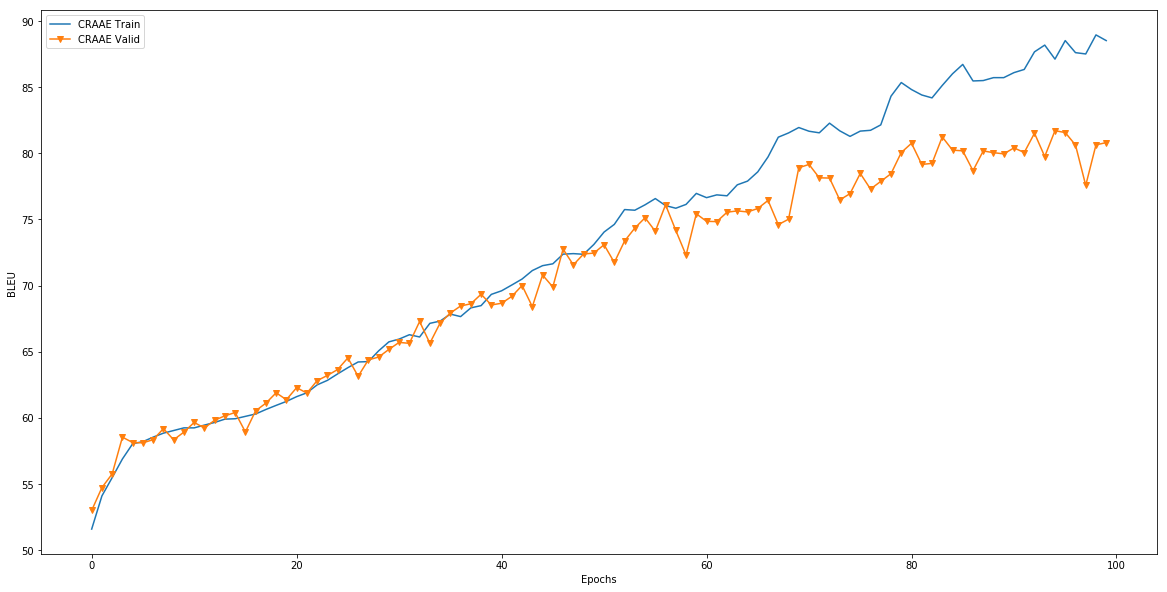

CPU times: user 8h 2min 35s, sys: 1h 43min 26s, total: 9h 46min 1s
Wall time: 10h 7min 41s


In [31]:
%%time

for epoch in range(1, 101):
    print("========== Start epoch {} at {} ==========".format(epoch, datetime.now().strftime("%H:%M:%S")))
    trn, val, _ = metrics['CRAAE']
    trn.append(train_raae(epoch, Enc, Dec, Disc, prior_size, train_dl))
    val.append(validate_raae(epoch, Enc, Dec, Disc, prior_size, valid_dl, 'Valid'))
    print_decoded(Enc, Dec, gen_dl)
    print_sample(Dec, sample_size=prior_size, max_seq_len=30)
            
    if epoch % 10 == 0: 
        torch.save(Enc.state_dict(), f'CAAE-1000H-3L.enc.e{epoch}.pt')
        torch.save(Dec.state_dict(), f'CAAE-1000H-3L.dec.e{epoch}.pt')
        torch.save(Disc.state_dict(), f'CAAE-1000H-3L.disc.e{epoch}.pt')
        plot_metrics(metrics, 0, 'AE Loss')
        plot_metrics(metrics, 1, 'Enc Loss')
        plot_metrics(metrics, 2, 'Disc Loss')
        plot_metrics(metrics, 3, 'BLEU')
        